# plot simulated and observed groundwater level at given well

In [250]:
# inline plot
# %matplotlib inline 
# interactive plot
%matplotlib notebook  
import numpy as np
import h5py as h5
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use('fast')
# inline_rc = dict(mpl.rcParams)
# mpl.rcParams.update(inline_rc) 
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
import ipdb
from scipy import interpolate
import pickle

In [2]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [3]:
# print both group and its member names
def printname(name):
    print(name)

## I/O files and parameters

In [31]:
#input
model_dir = "/Users/shua784/Paraview/HFR/HFR_200x200x2_6h_bc/"
fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran_200x200x2_6h_bc_test.h5"
fname_300A_h5 = "/Users/shua784/Paraview/300A/John_case_optim_5/pflotran_bigplume-004.h5"

data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
fname_300A_well_screen = data_dir + "Monitoring_Well_Screen_bigdomain.csv"
fname_300A_well_data = data_dir + 'well_data/SFA_all_wells.csv'

#output
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_6h_bc/"
fig_wl = out_dir + 'wl/'
fig_simu_obs_wl = out_dir + "simu_obs_wl/"

result_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/results/HFR_model_200x200x2_6h_bc/"
fname_well_simu_data_pk = result_dir + "well_simu_data.p"


In [5]:
P_atm = 101325
rho = 997.16
g_const = 9.81

z_bot = 0
z_top = 200


In [6]:
date_origin = datetime.strptime("2007-03-28 00:00:00", "%Y-%m-%d %H:%M:%S")
# read model origin
model_origin = np.genfromtxt(fname_model_origin, delimiter=" ", skip_header=1)

## import well data

In [7]:
# import obs well locations
well_loc = pd.read_csv(fname_300A_well_screen, index_col= ['wellname1'])
# print(well_loc.head(5))

well_loc['Easting'] = well_loc['Easting'] - model_origin[0]
well_loc['Northing'] = well_loc['Northing'] - model_origin[1]

# import obs well data
well_data = pd.read_csv(fname_300A_well_data)
# print(well_data.head(5))

In [8]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)
section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000

line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

## read model dim, time index from hdf5 output file

In [ ]:
# all_h5 = glob.glob(fname_pflotran_h5) # find all "pflotran*.h5" files
# all_h5 = np.sort(all_h5)

input_h5 = h5.File(fname_pflotran_h5, "r")

# input_h5.visit(printname)

x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
# input_h5.close()

dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)

# x,y,z coordinates at cell center
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# generate mesh grid
xx, yy = np.meshgrid(x, y)

# create grids (nx*ny*nz, 3)--a list of arrays based nx, ny, nz
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

groups = list(input_h5.keys()) # create a list with group names
time_index = [s for s, s in enumerate(groups) if "Time:" in s] # enumerate returns its index (index, string)

In [70]:
real_time_index = []
for itime in np.arange(len(time_index)):
    itime_str = list(batch_delta_to_time(date_origin, [float(time_index[itime][7:18])], "%Y-%m-%d %H:%M:%S", "hours"))
    itime_str = ''.join(itime_str)
    real_time_index.append(datetime.strptime(itime_str, "%Y-%m-%d %H:%M:%S"))

## read river cell information from material h5 file

In [10]:
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 
# read river cell ids
river_cells = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
river_cells = np.unique(river_cells).astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
# label river cells in x-y plane with '1'
yx_river = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx) # initialize ny*nx array with nan value, because python read column first (y,x)
for icell in river_cells:
    yx_river[grids[icell, 1], grids[icell, 0]] = 1
    
material_h5.close()

## calculate simulated head
We can calculate total head by $$H = h + z, (h = (P-P_{atm})/\gamma/g)$$  
which $h$ has shape of **(100, 300, 300)**, and $z$ has shape of **(100,)**. To use broadcasting rule, the dimension of two arrays must match or either one has $dim = 1$. In this case, $z$ is reshaped to **(100, 1, 1)**. that is $$ H(100, 300, 300) = h(100,300,300) + z(100, 1, 1) $$


note: when importing hdf5 dataset of dimension **(nx, ny, nz)**, the shape of numpy array will be **(nx, ny, nz)**. The correct logical shape in numpy would need to change to **(nz, ny, nx)** by using `np.swapaxes(0, 2)`.

### Using interpolation to get well obs data at given location
notes about using scipy.interpolate:
* `interpolate.Rbf` performs best for irregular dataset compared to `interpolate.interp2d` and `interpolate.griddata` and can do both interpolation and extrapolation, however, it is **extremely slow** for large dataset. (see this [post](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy))
* `interpolate.RectBivariateSpline` is fast for structured grid, however, it will return NaN if there is missing data in the inputs. A work around is to replace those missing data with 0 or -9999. After interpolation, set those missing data to NaN again. (see this [post](https://stackoverflow.com/questions/15485343/bivariate-structured-interpolation-of-large-array-with-nan-values-or-mask))
* `interpolate.griddata` does not perform extrapolation. Need to test its performance against large dataset.

In [267]:
well_simu_head = np.empty((len(time_index), nz, len(well_loc.index))) # initialize array to store simu.head at obs.wells
well_abs_flux = np.empty((len(time_index), nz, len(well_loc.index))) # initialize array to store abs.flux at obs.wells
well_tracer = np.empty((len(time_index), nz, len(well_loc.index))) # initialize array to store tracer conc. at obs.wells

# create index for well screen intervals
interval_index = np.where((z > np.min(well_loc['SCREEN_ELEV_BOTTOM'])) & (z < np.max(well_loc['SCREEN_ELEV_TOP'])))
interval_index = np.asarray(interval_index).flatten()
# print(well_simu_head.shape, type(interval_index), interval_index.shape)

In [266]:
# loop over time step
for itime in np.arange(len(time_index))[0:2]:
#         ipdb.set_trace()
    print(time_index[itime])
    real_itime = batch_delta_to_time(date_origin, [float(time_index[itime][7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = str(real_itime)
    print(real_itime, type(real_itime))
    # read pressure
    temp_pressure = np.asarray(list(input_h5[time_index[itime]]["Liquid_Pressure [Pa]"])).swapaxes(0,2)
    temp_pressure[temp_pressure == 0] = np.nan # replace 0 (inactive cell pressure) with nan to avoid calculations

    # convert liquid_pressure to pressure head
    temp_head = (temp_pressure - P_atm) / rho / g_const
    # reshape z to use broadcasting rule
    z_reshape = z.reshape(nz, 1, 1)
    # total head  = presure head + elevation head
    temp_total_head = temp_head + z_reshape

    # create a copy of total_head and replace nan with 0
    total_head_copy = temp_total_head.copy()
    total_head_copy = np.nan_to_num(total_head_copy) # replace nan with 0
    
    # calculate ave. tracer conc. at wells
    xflux = np.asarray(list(input_h5[time_index[itime]]['Liquid X-Flux Velocities'])).swapaxes(0,2)
    yflux = np.asarray(list(input_h5[time_index[itime]]['Liquid Y-Flux Velocities'])).swapaxes(0,2)
    abs_flux = np.sqrt((xflux**2 + yflux**2))
    
    temp_tracer = np.asarray(list(input_h5[time_index[itime]]['Total_Tracer [M]'])).swapaxes(0,2)
    
    # interpolate head at each iz layer
    for iz in interval_index:
        f_head = interpolate.RectBivariateSpline(y, x, total_head_copy[iz, :,:])
        f_abs_flux = interpolate.RectBivariateSpline(y, x, abs_flux[iz, :,:])
        f_tracer = interpolate.RectBivariateSpline(y, x, temp_tracer[iz, :,:])
        # evaluate at well points
        well_simu_head[itime, iz, :] = f_head.ev(well_loc['Northing'], well_loc['Easting']) 
        well_abs_flux[itime, iz, :] = f_abs_flux.ev(well_loc['Northing'], well_loc['Easting'])
        well_tracer[itime, iz, :] = f_tracer.ev(well_loc['Northing'], well_loc['Easting'])
    
    

Time:  3.24000E+04 h
['2010-12-07 00:00:00'] <class 'str'>


ValueError: operands could not be broadcast together with shapes (100,300,299) (100,299,300) 

In [219]:
pickle.dump(well_simu_head, open(fname_well_simu_data_pk, "wb"))

### plot well simu vs obs head

399-1-13A
399-1-16A


<IPython.core.display.Javascript object>


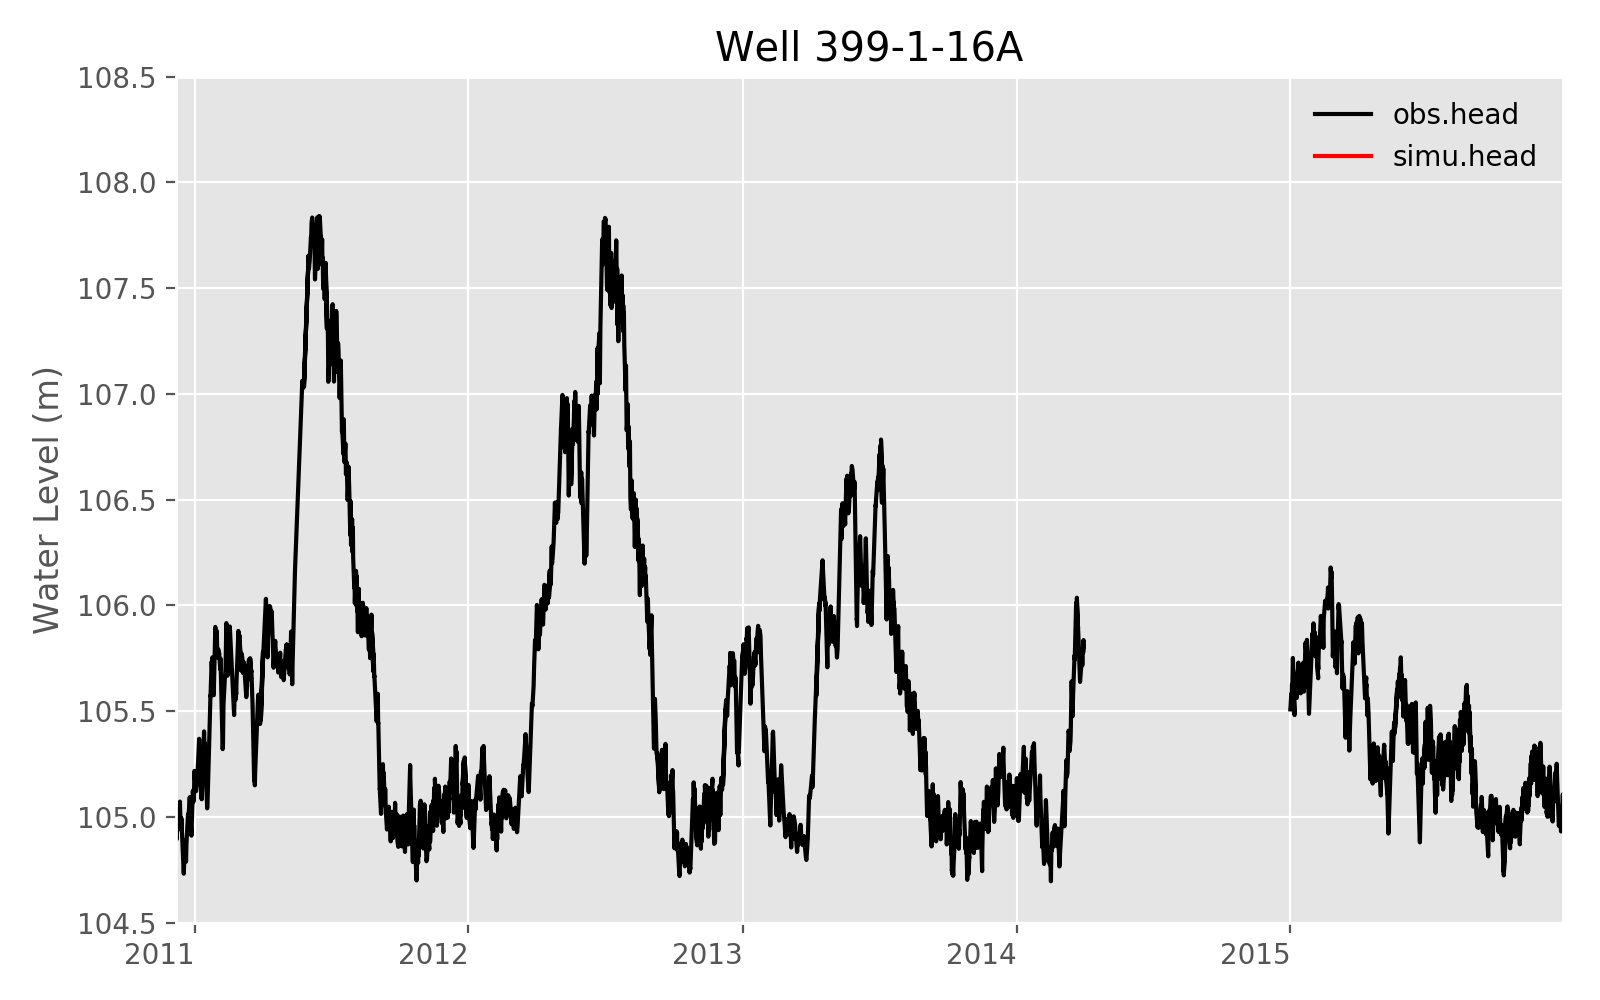

399-1-17A


<IPython.core.display.Javascript object>


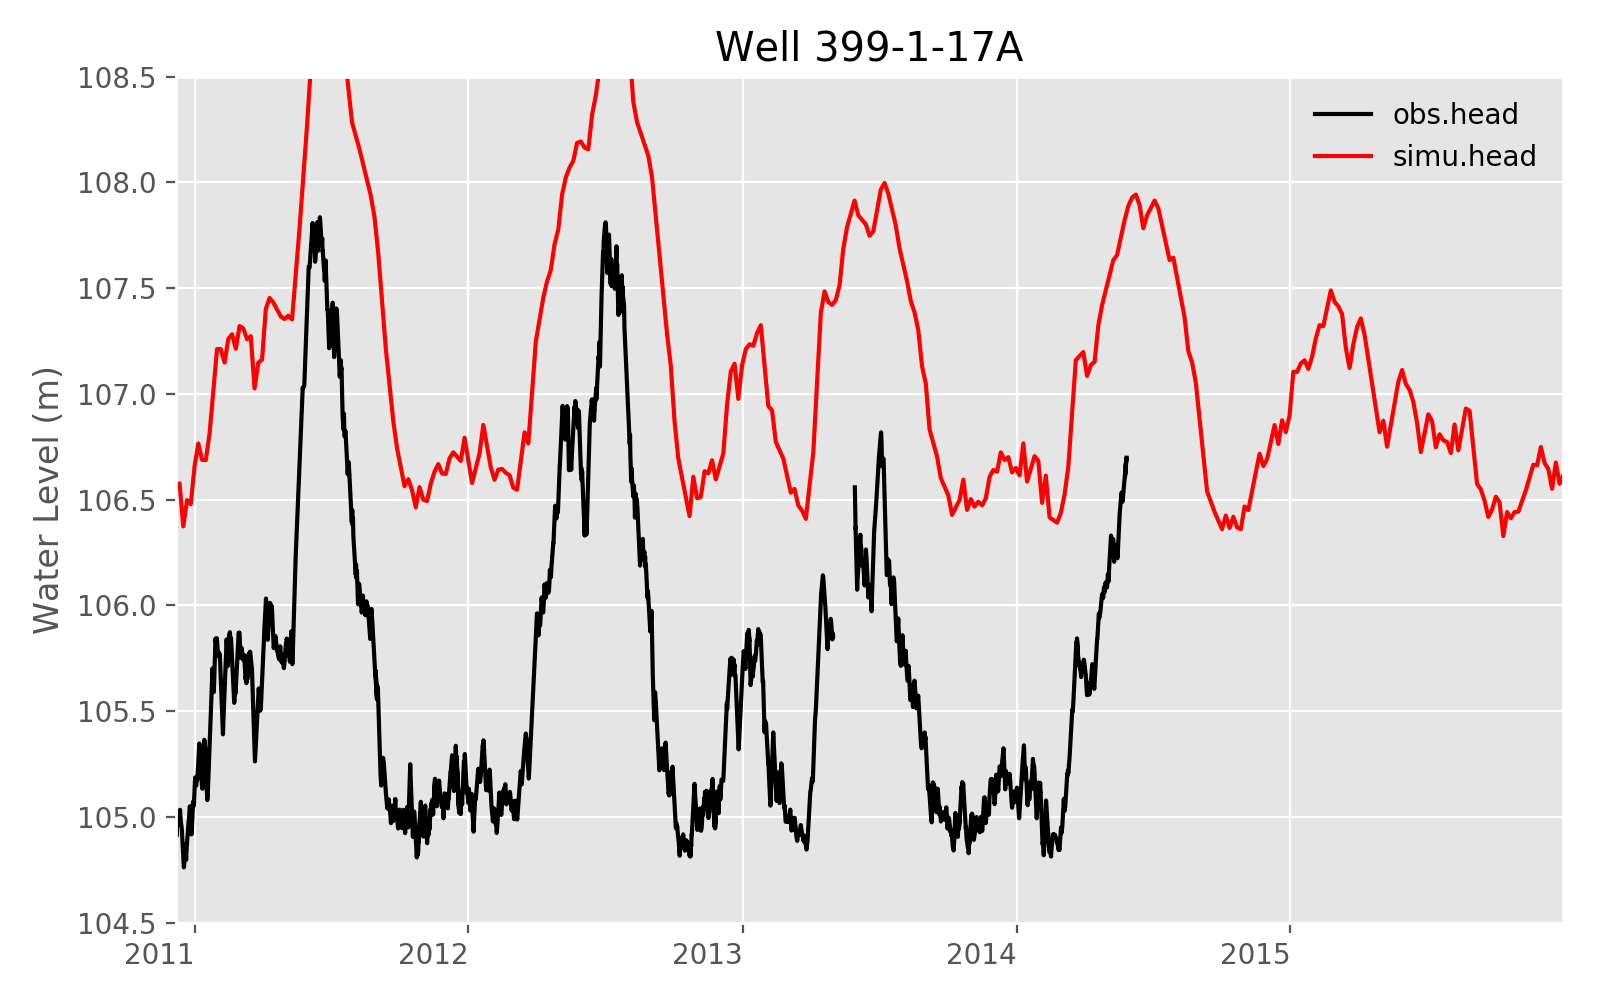

399-1-21A


<IPython.core.display.Javascript object>


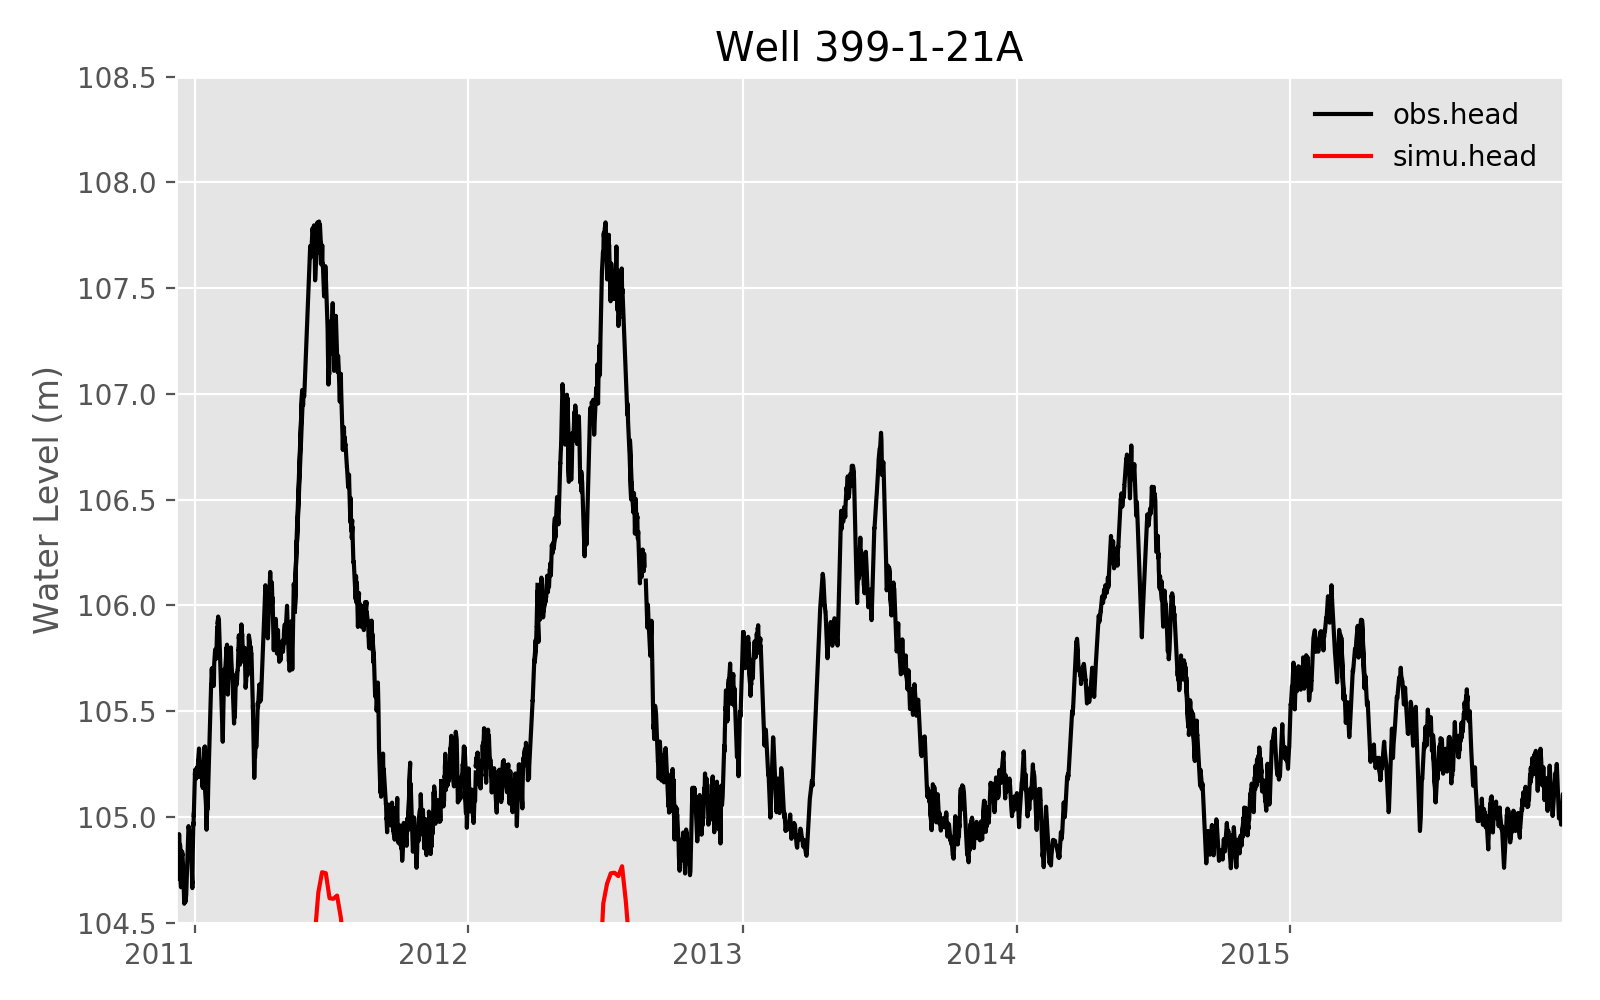

399-1-23


<IPython.core.display.Javascript object>


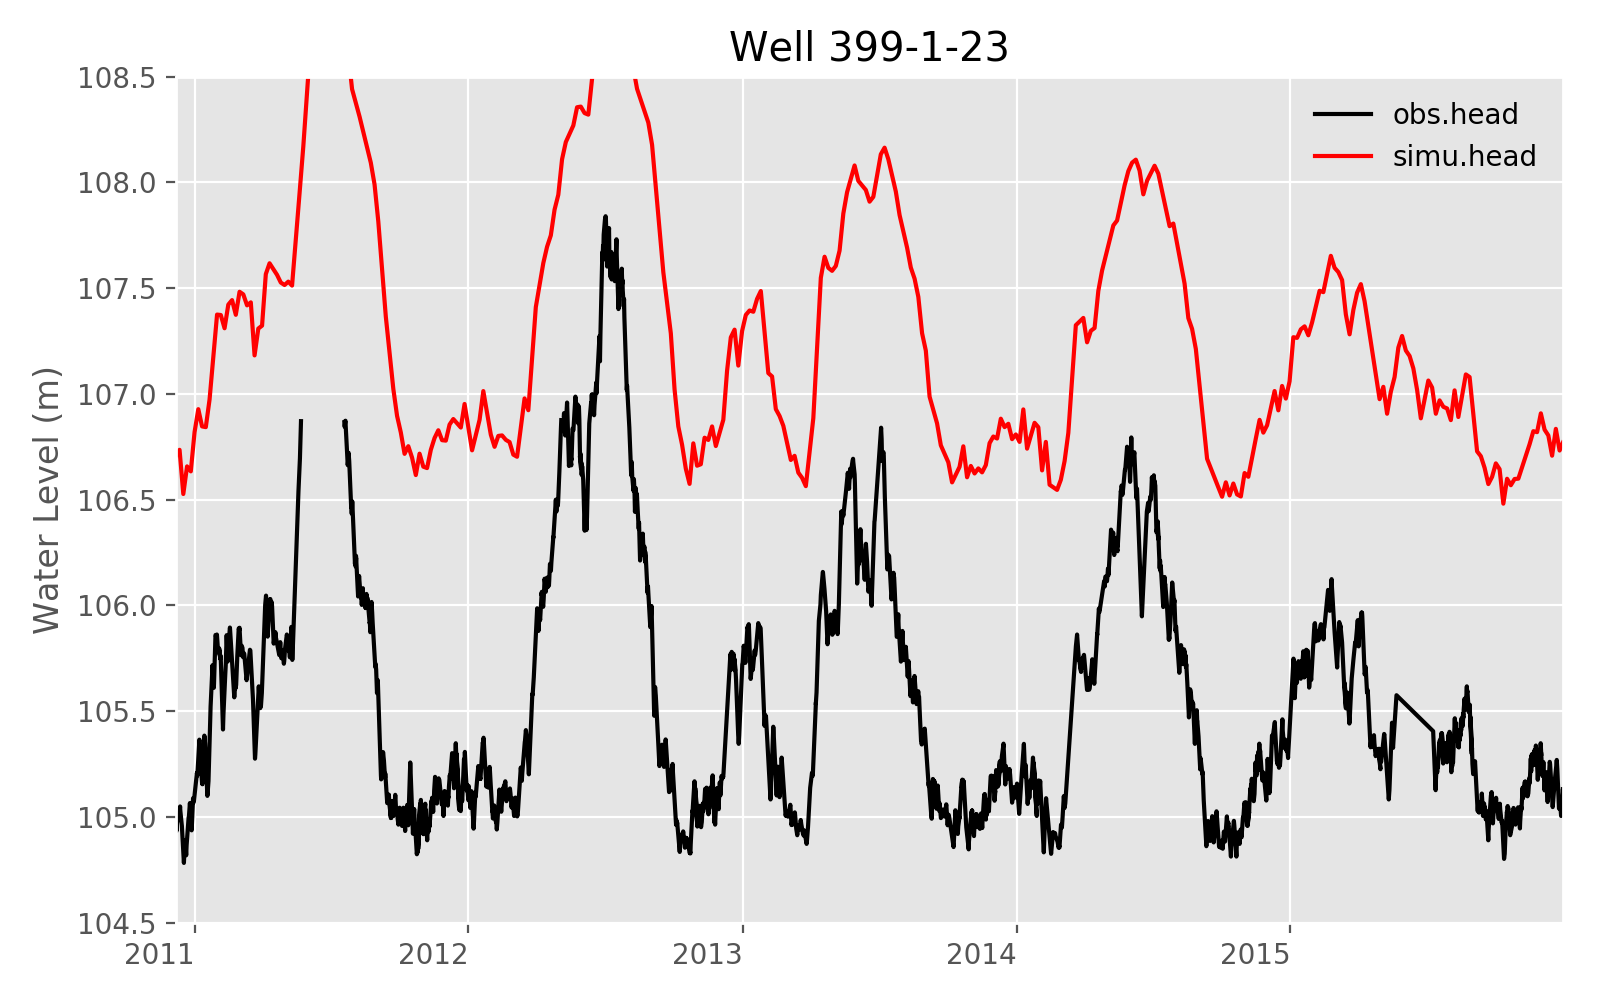

399-1-32


<IPython.core.display.Javascript object>


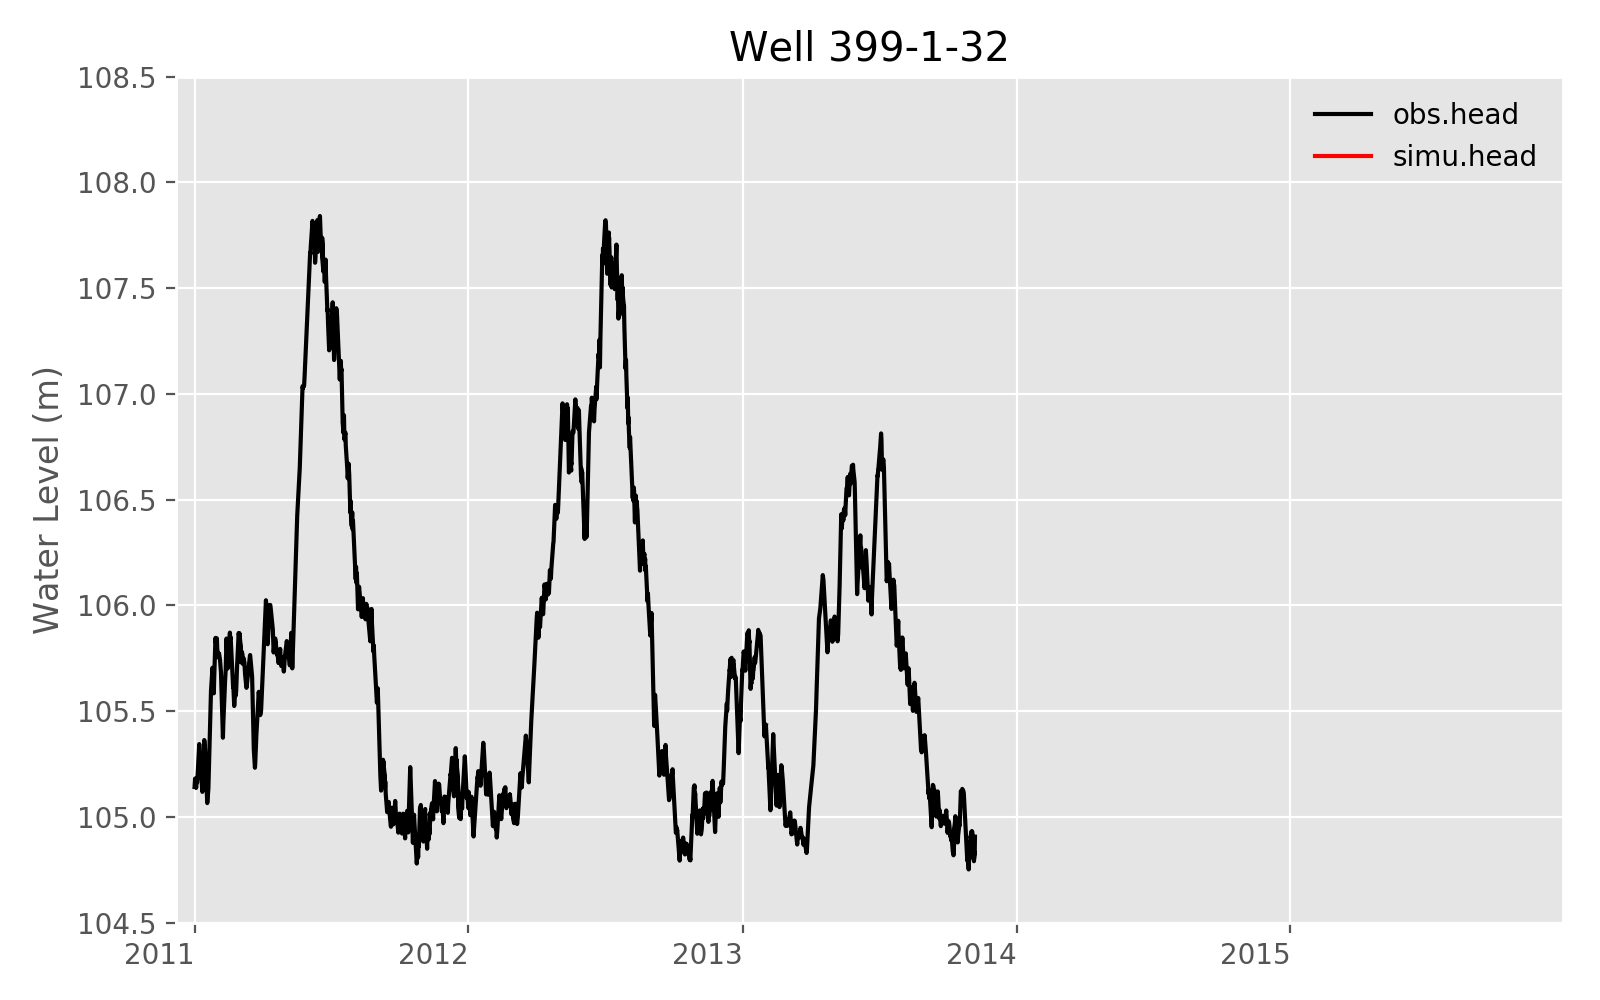

399-1-60


<IPython.core.display.Javascript object>


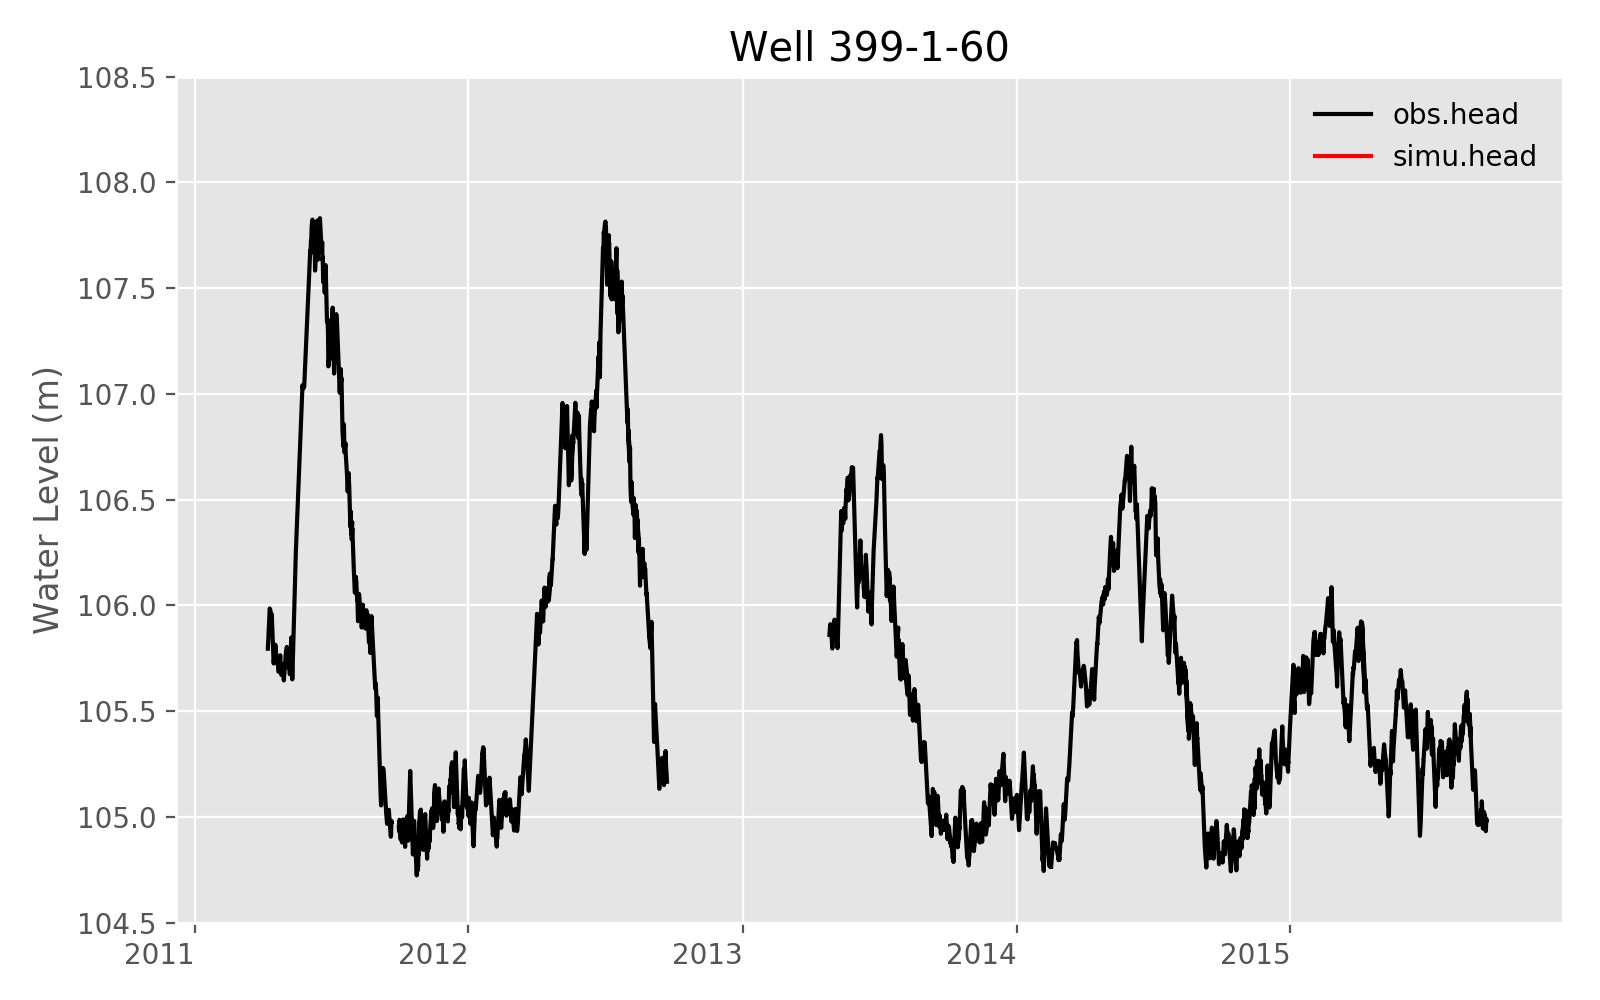

399-2-1


<IPython.core.display.Javascript object>


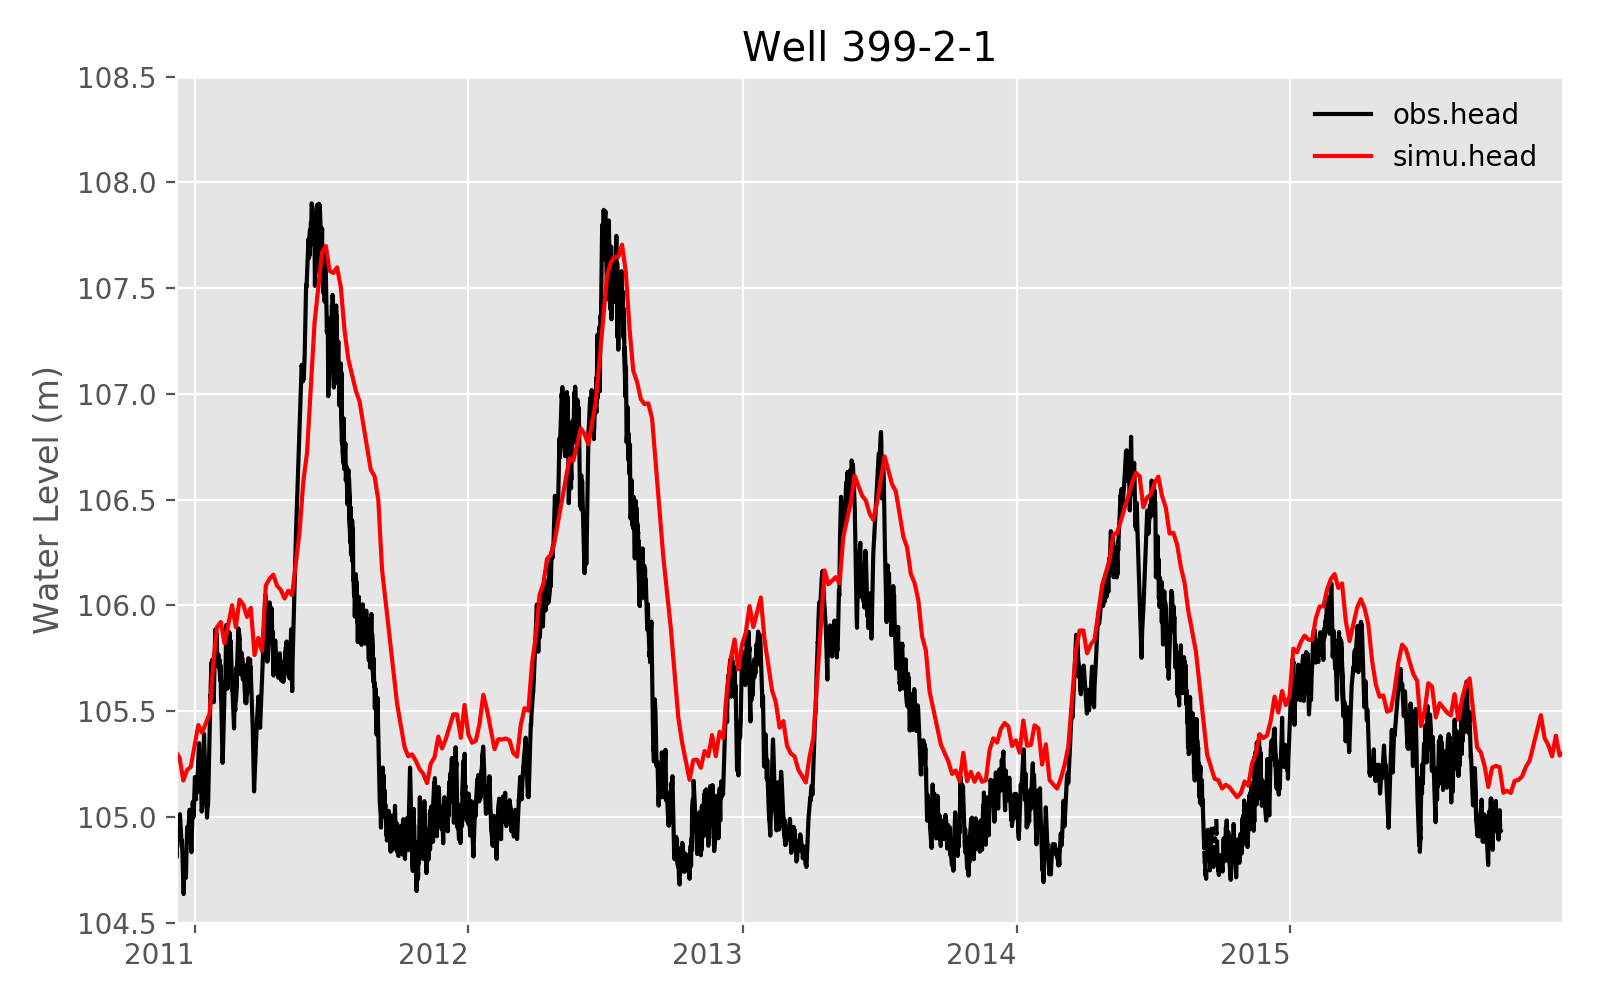

399-2-2


<IPython.core.display.Javascript object>


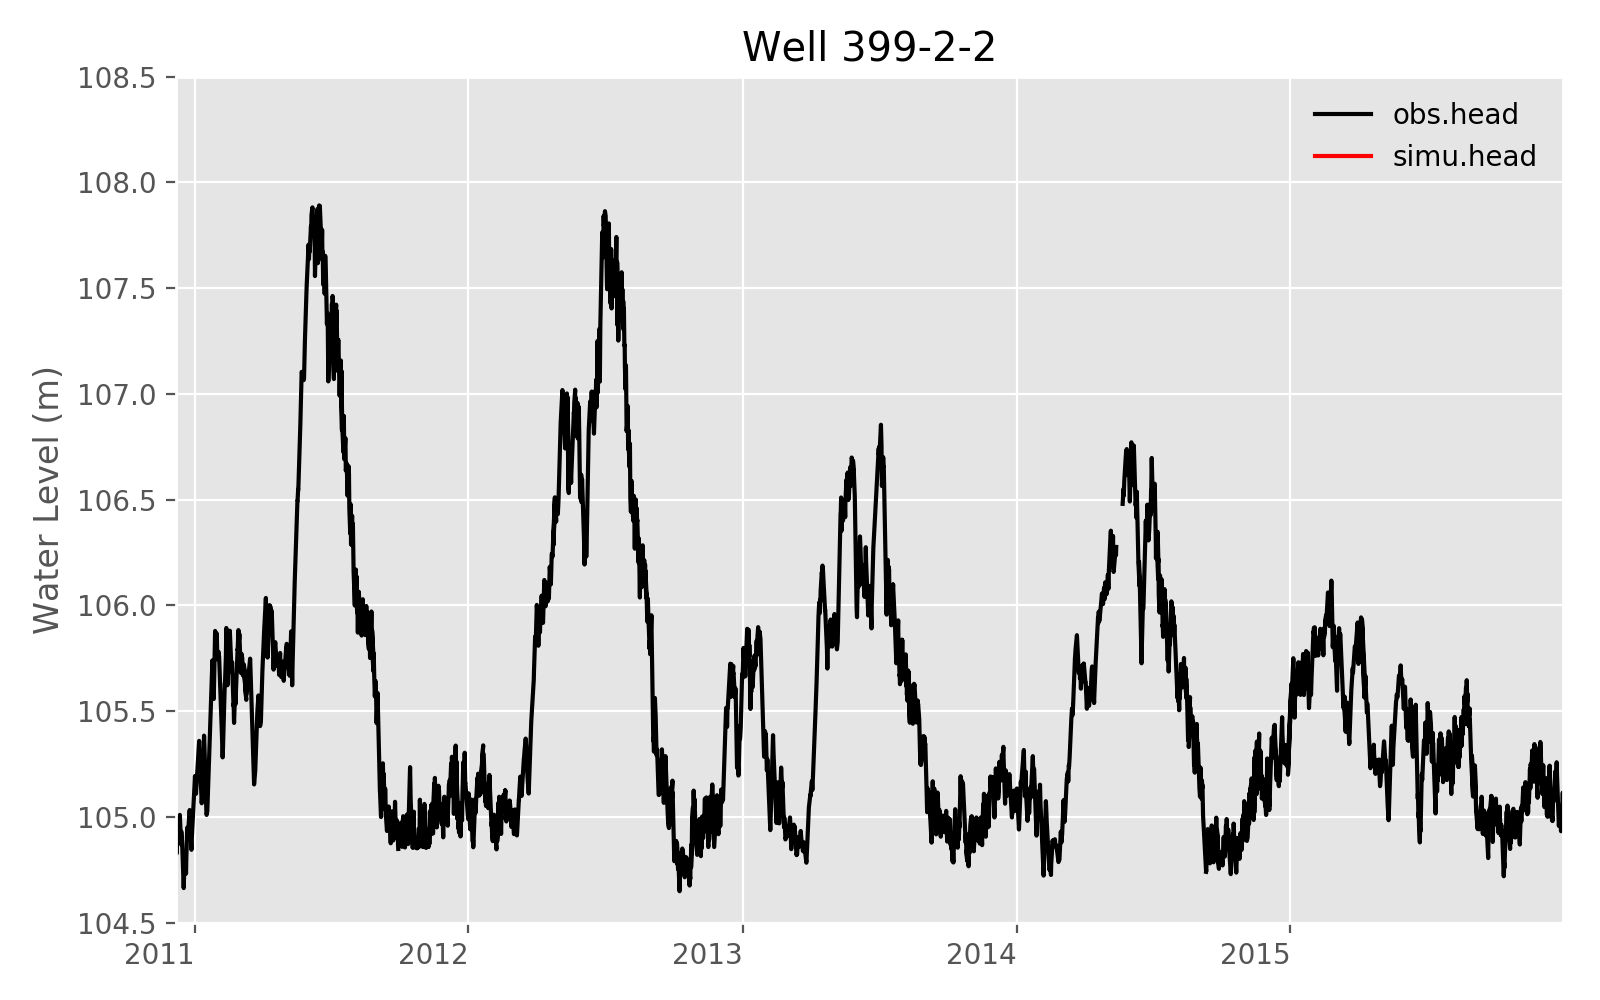

399-2-3


<IPython.core.display.Javascript object>


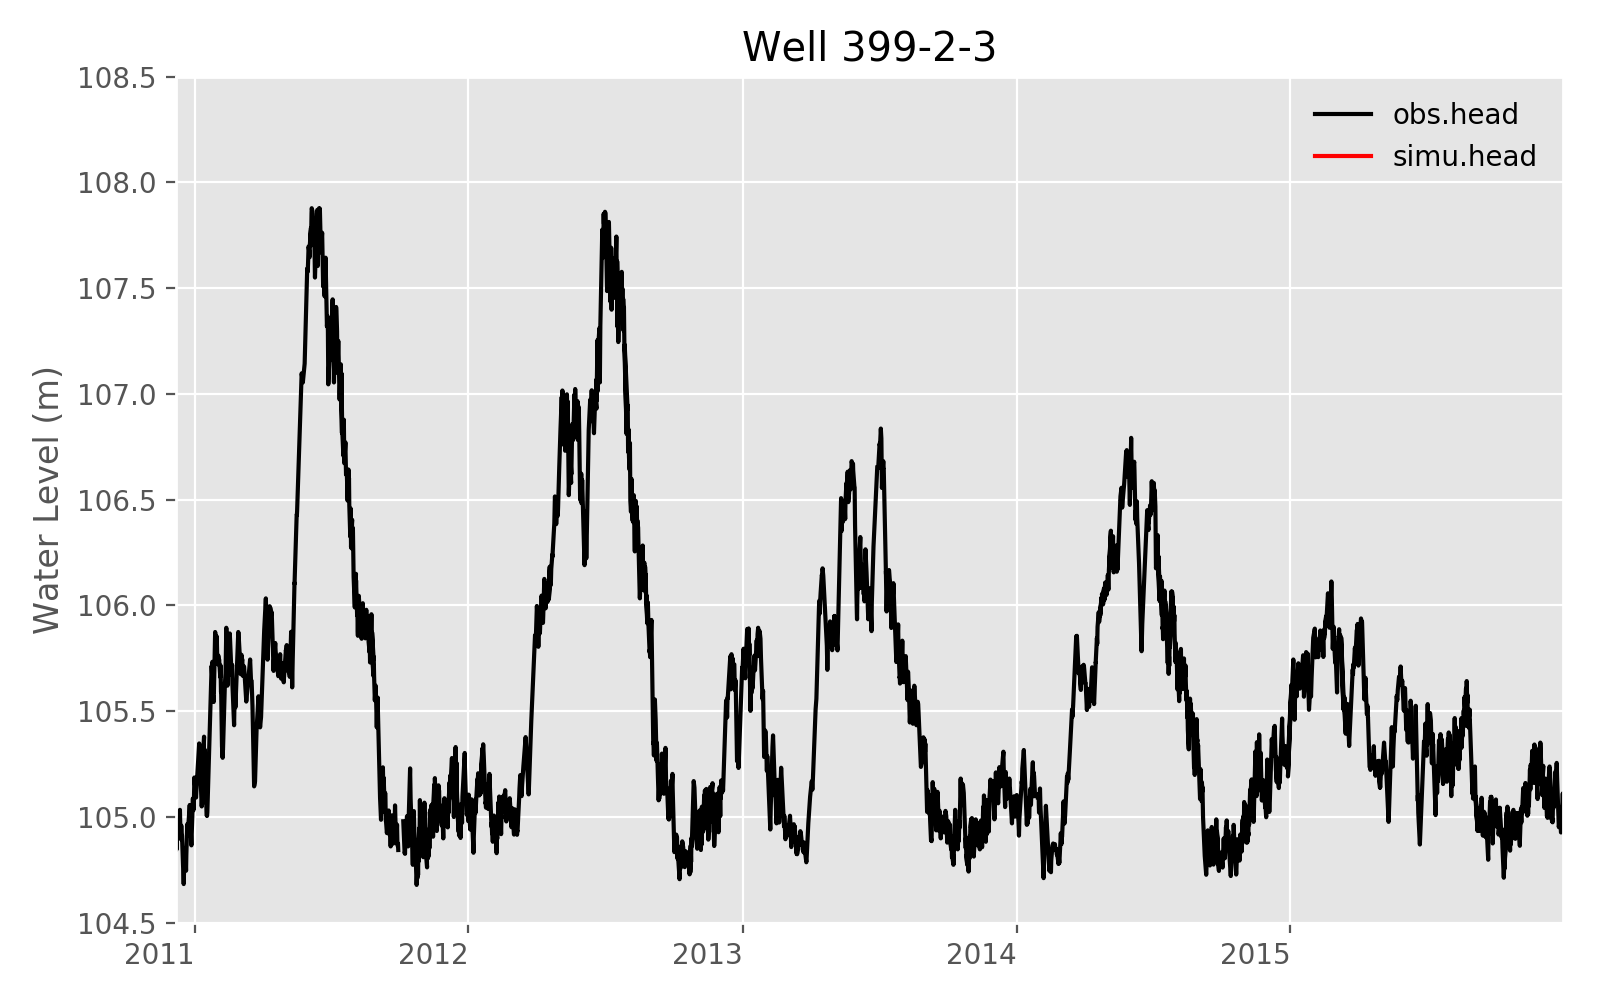

399-2-5


<IPython.core.display.Javascript object>


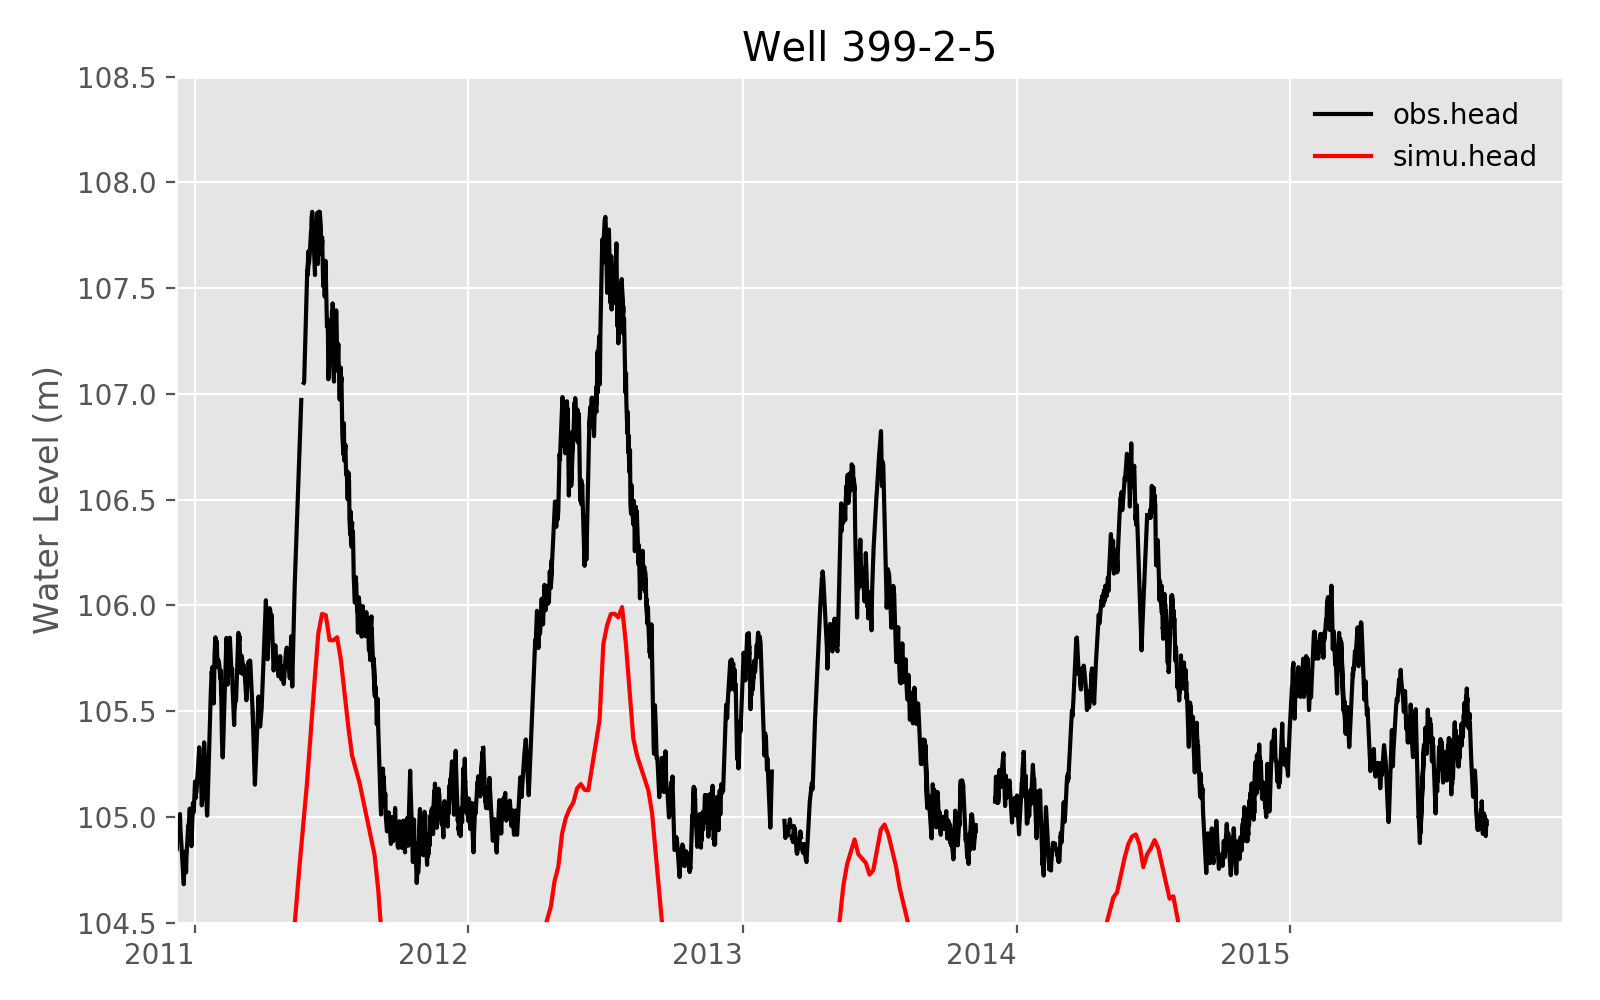

399-2-7
399-2-10


<IPython.core.display.Javascript object>


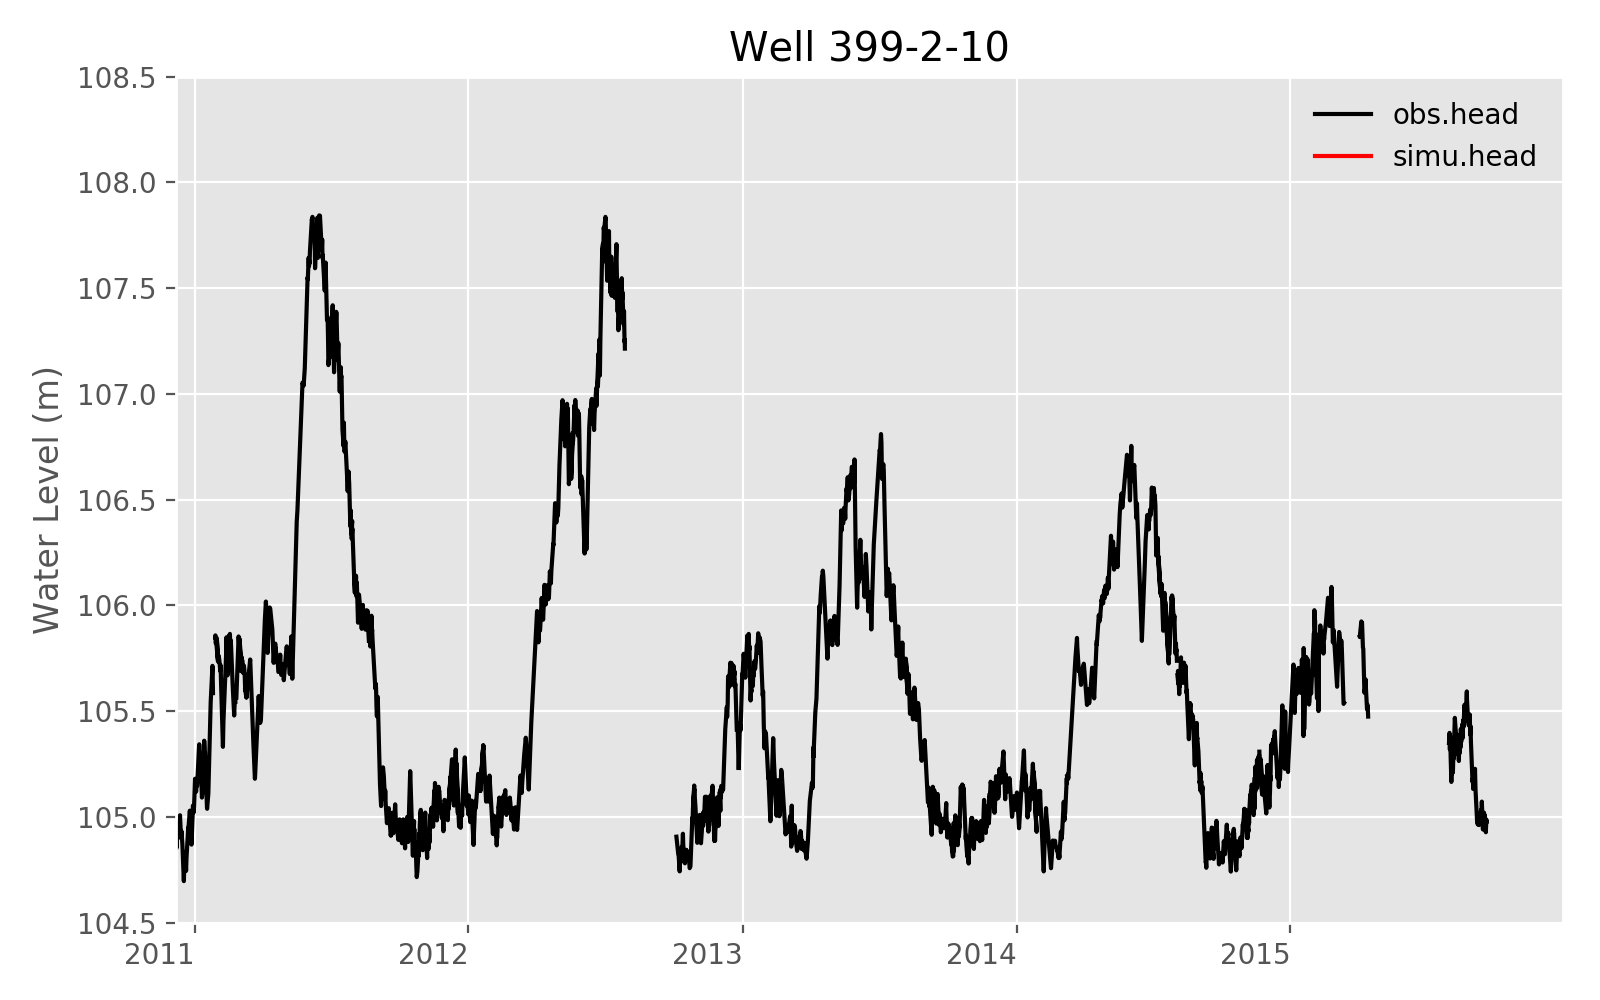

399-2-23
399-2-25


<IPython.core.display.Javascript object>


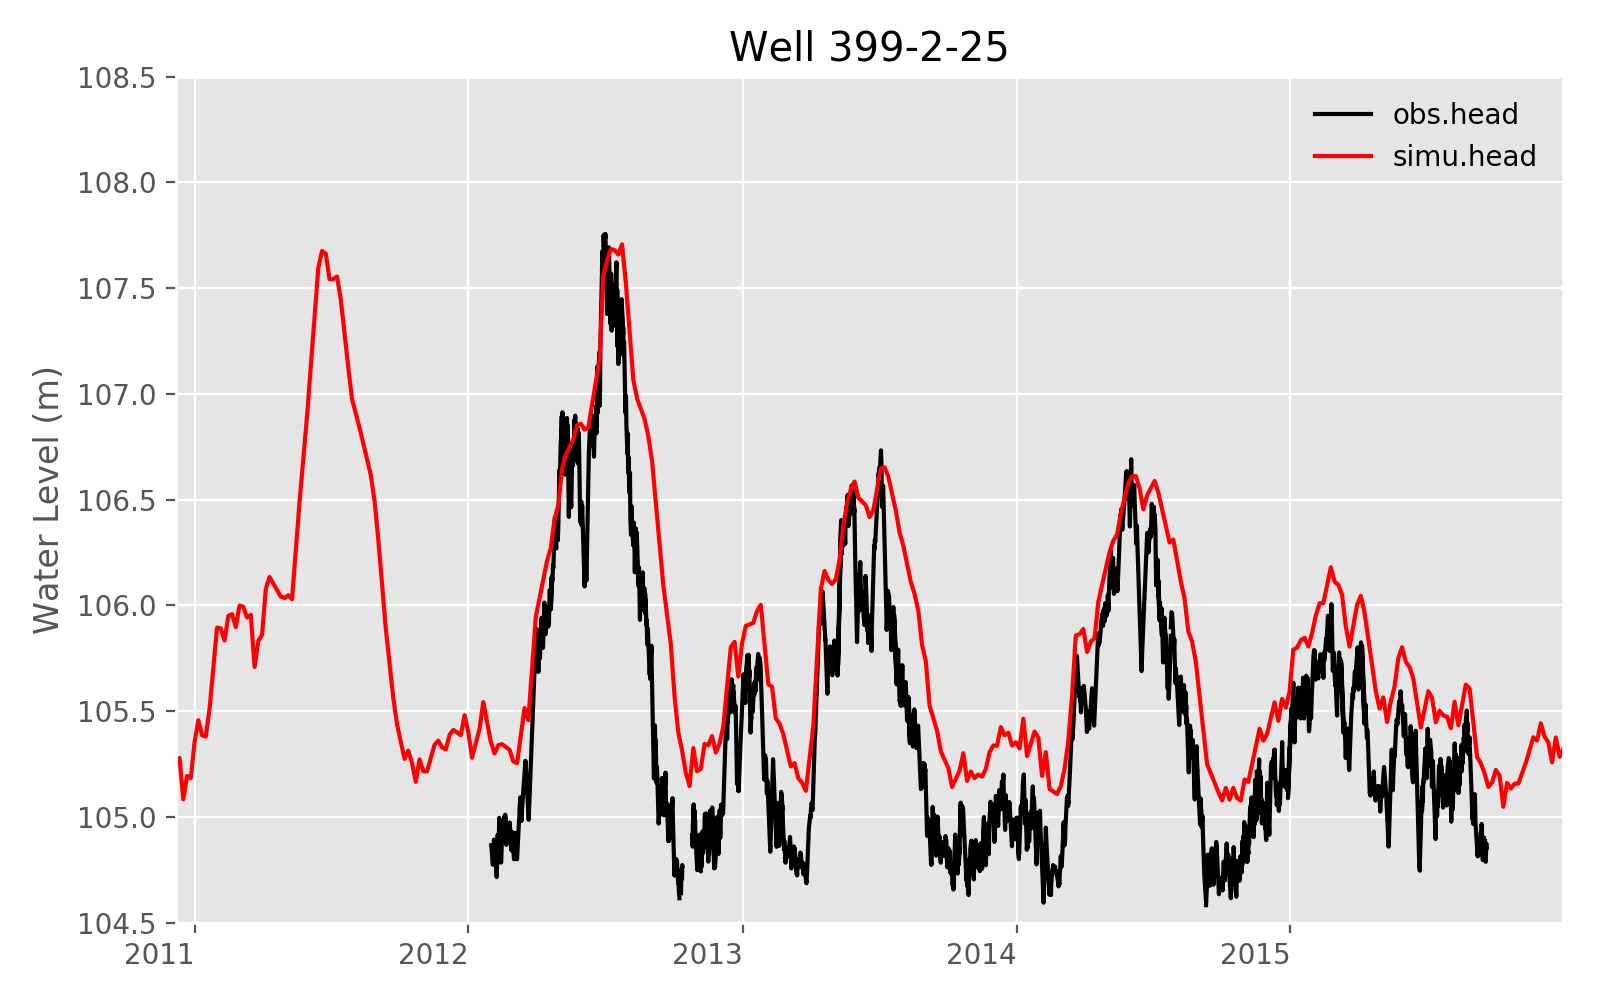

399-2-32


<IPython.core.display.Javascript object>


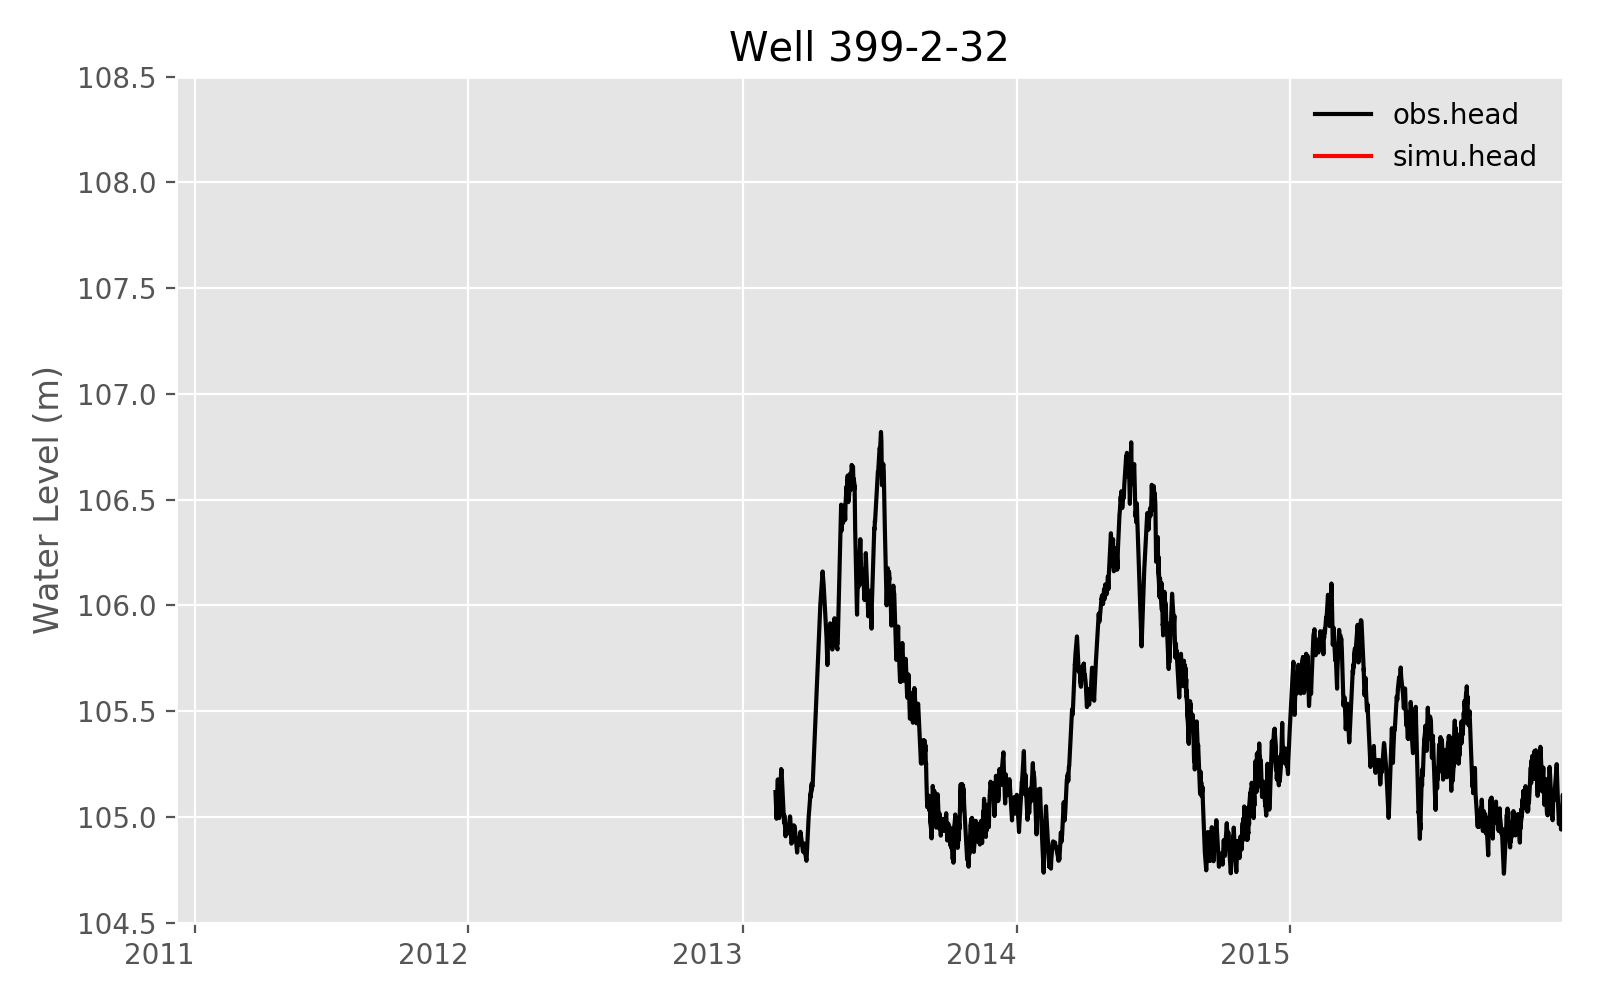

399-2-33


<IPython.core.display.Javascript object>


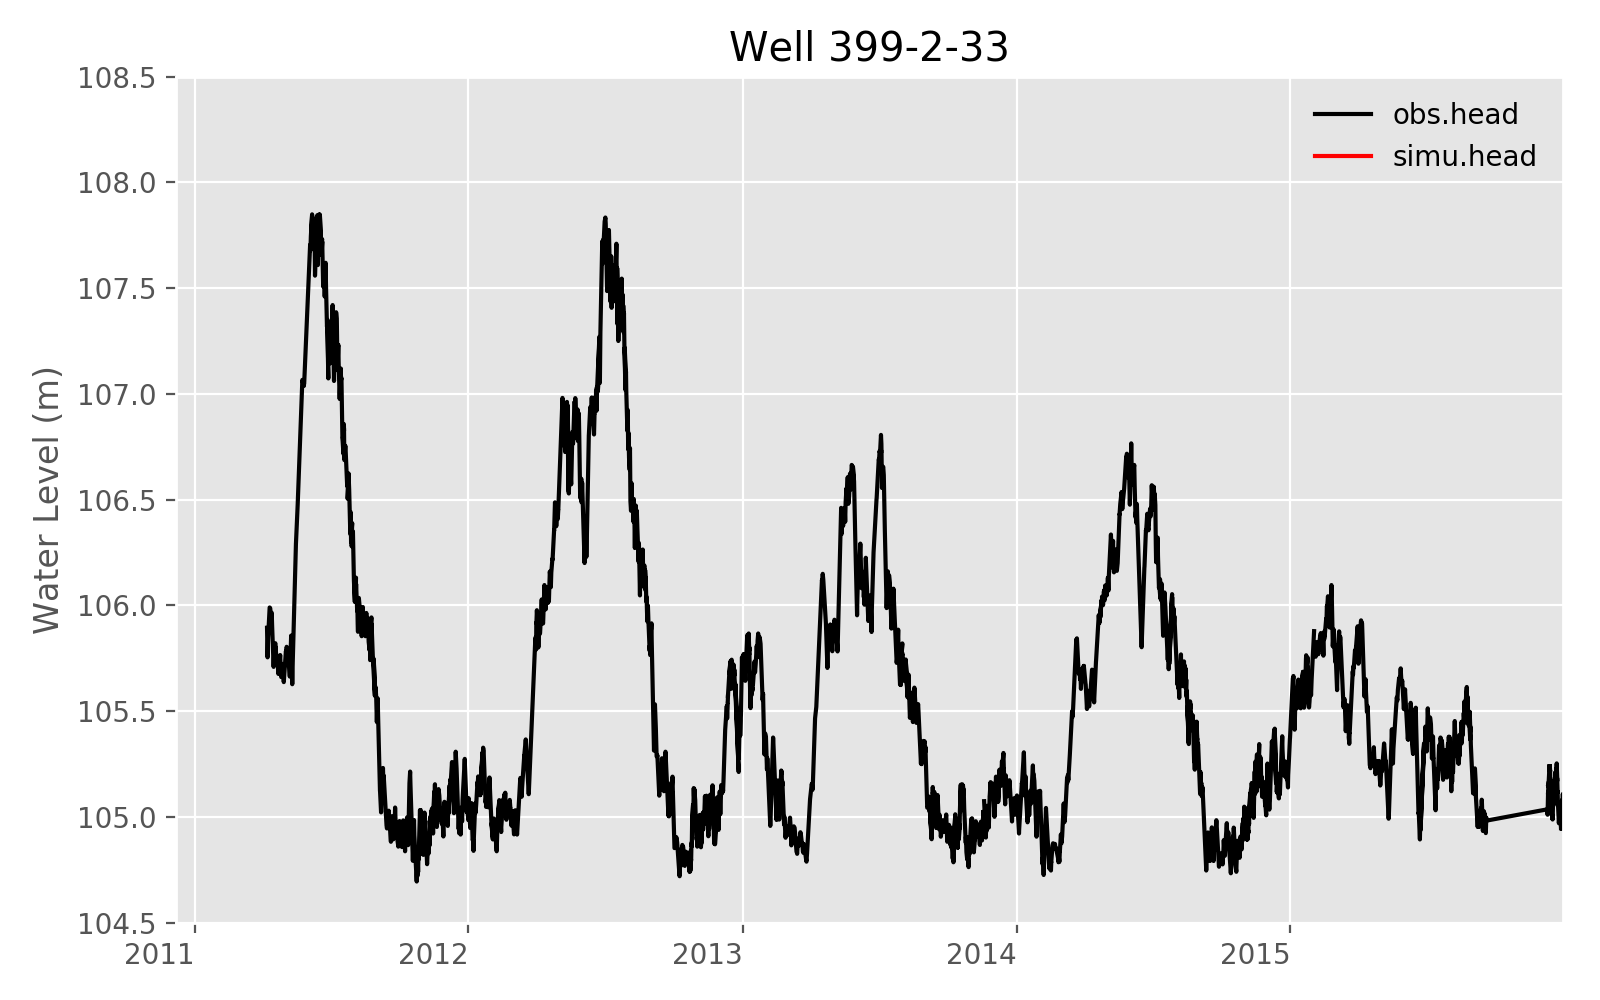

399-2-34
399-2-37
399-3-9


<IPython.core.display.Javascript object>


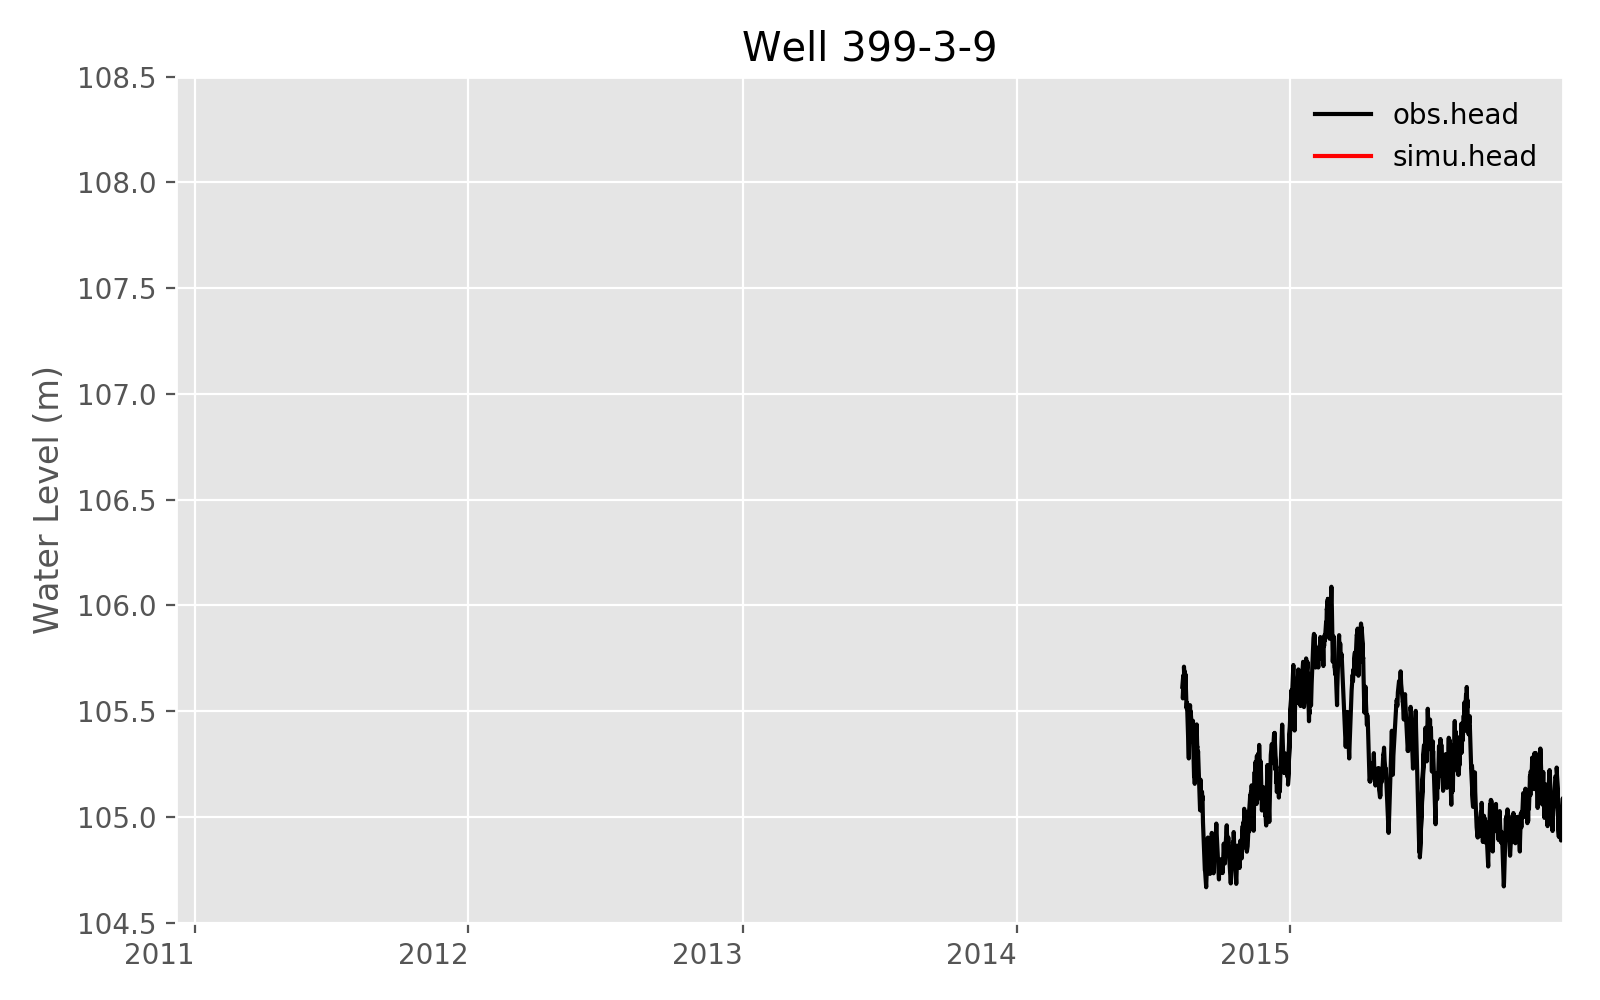

399-3-12
399-3-18


<IPython.core.display.Javascript object>


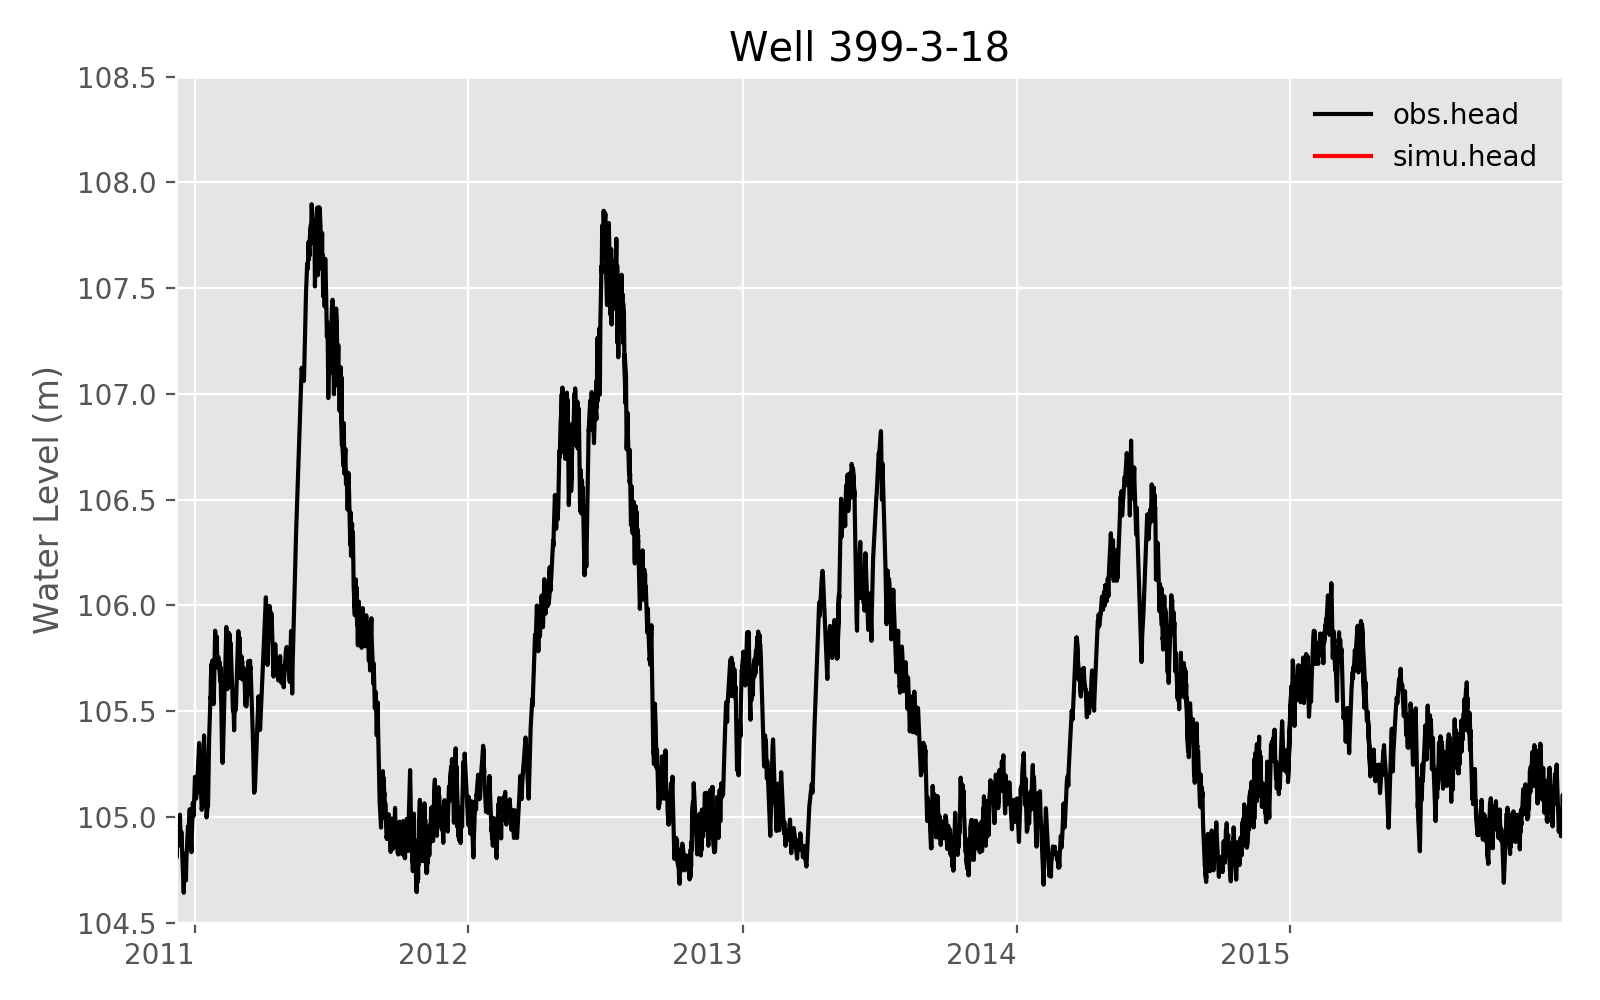

399-3-19


<IPython.core.display.Javascript object>


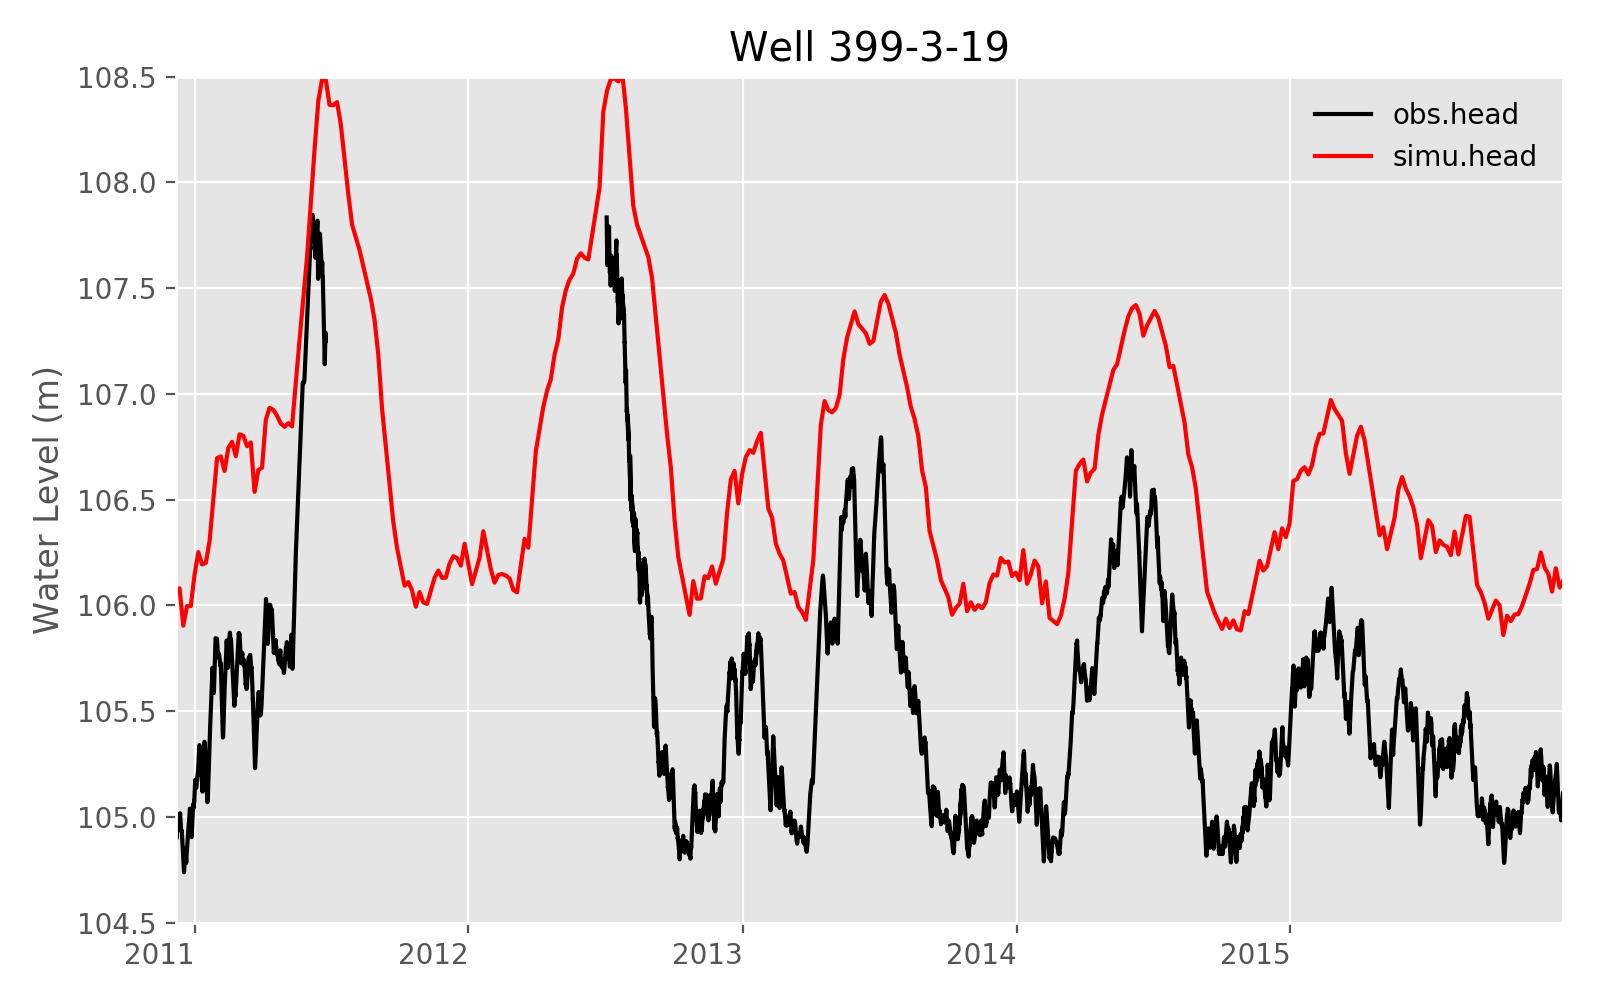

399-3-20


<IPython.core.display.Javascript object>


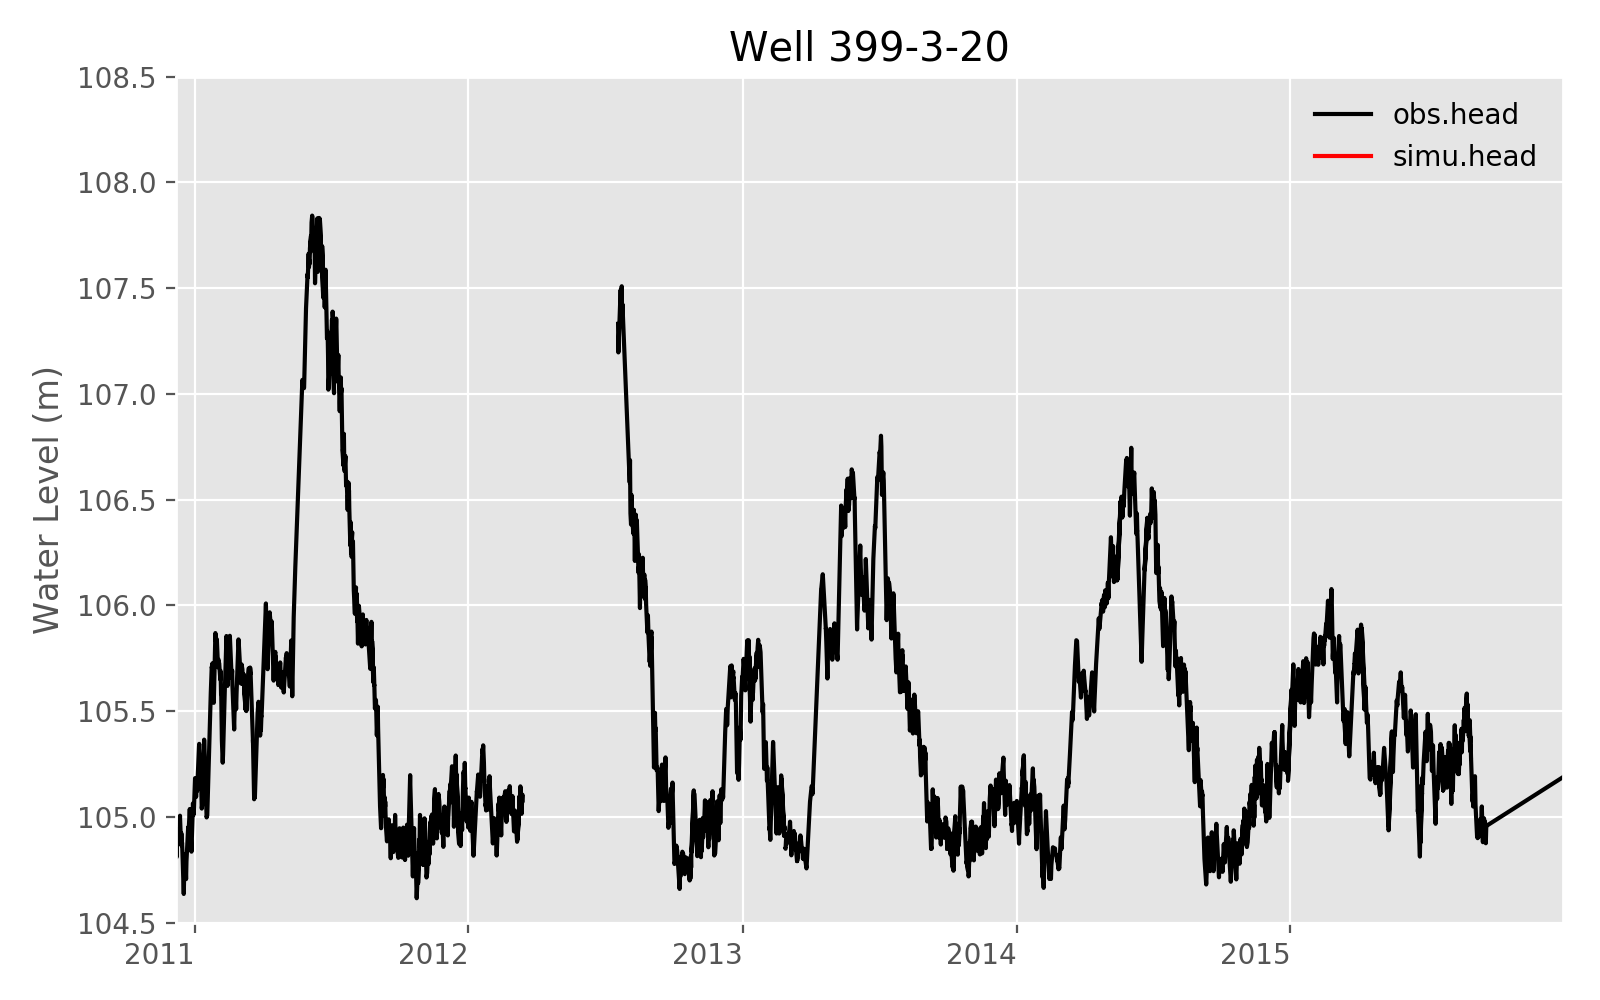

399-3-21


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


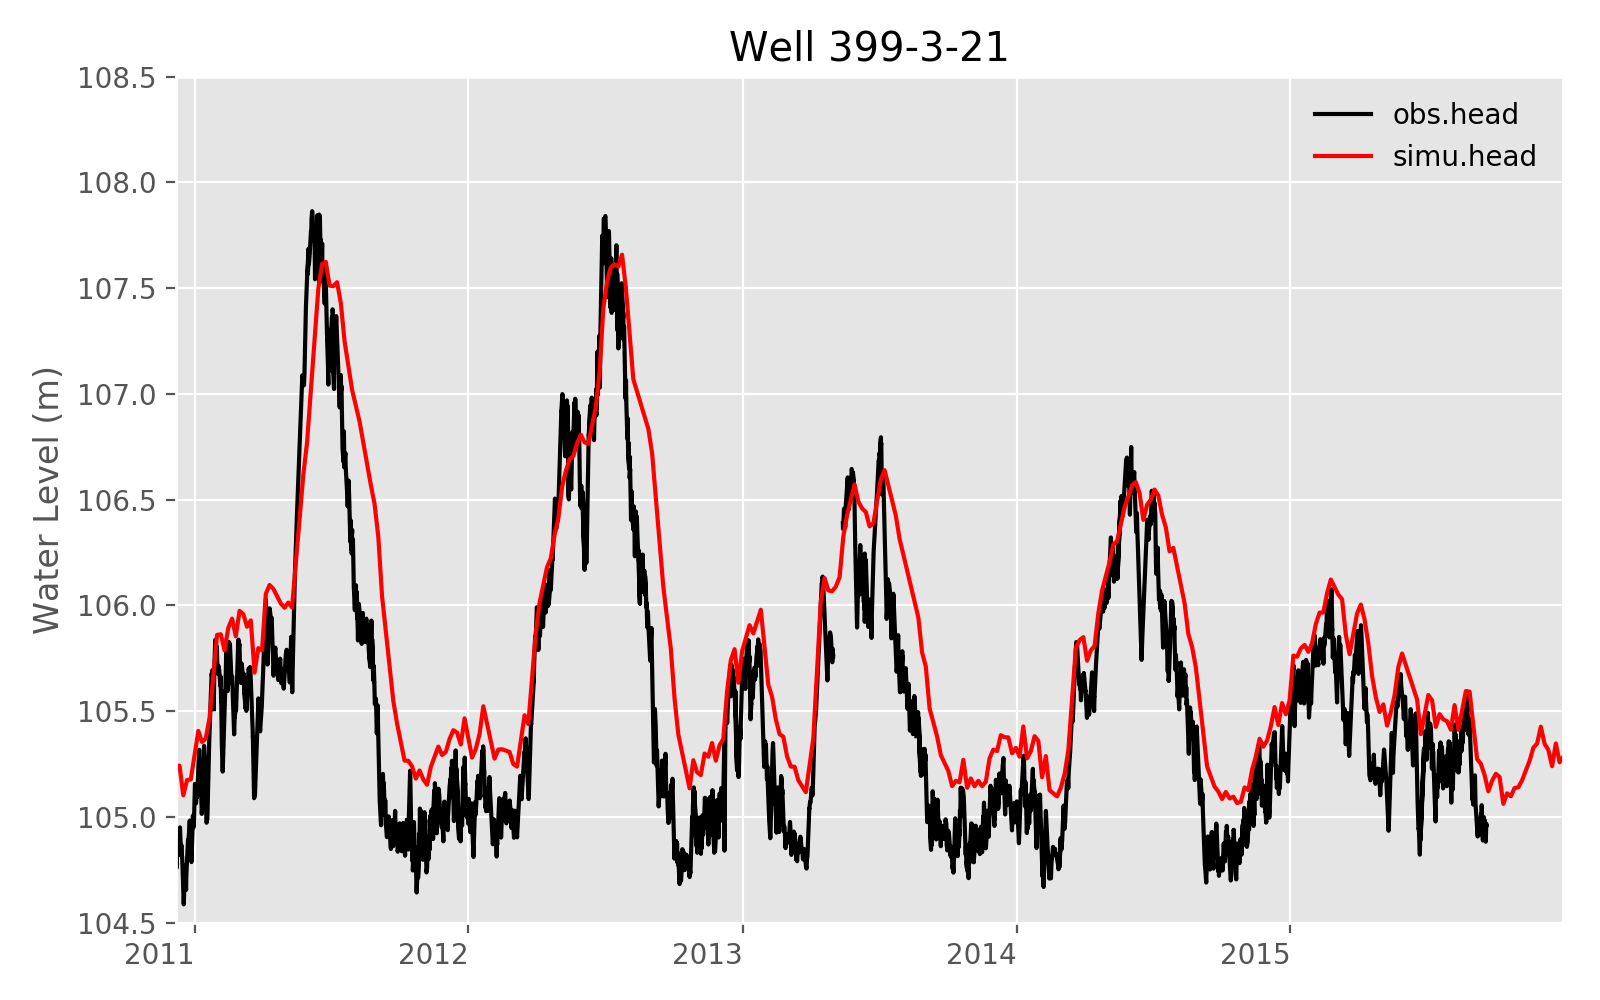

399-3-22


<IPython.core.display.Javascript object>


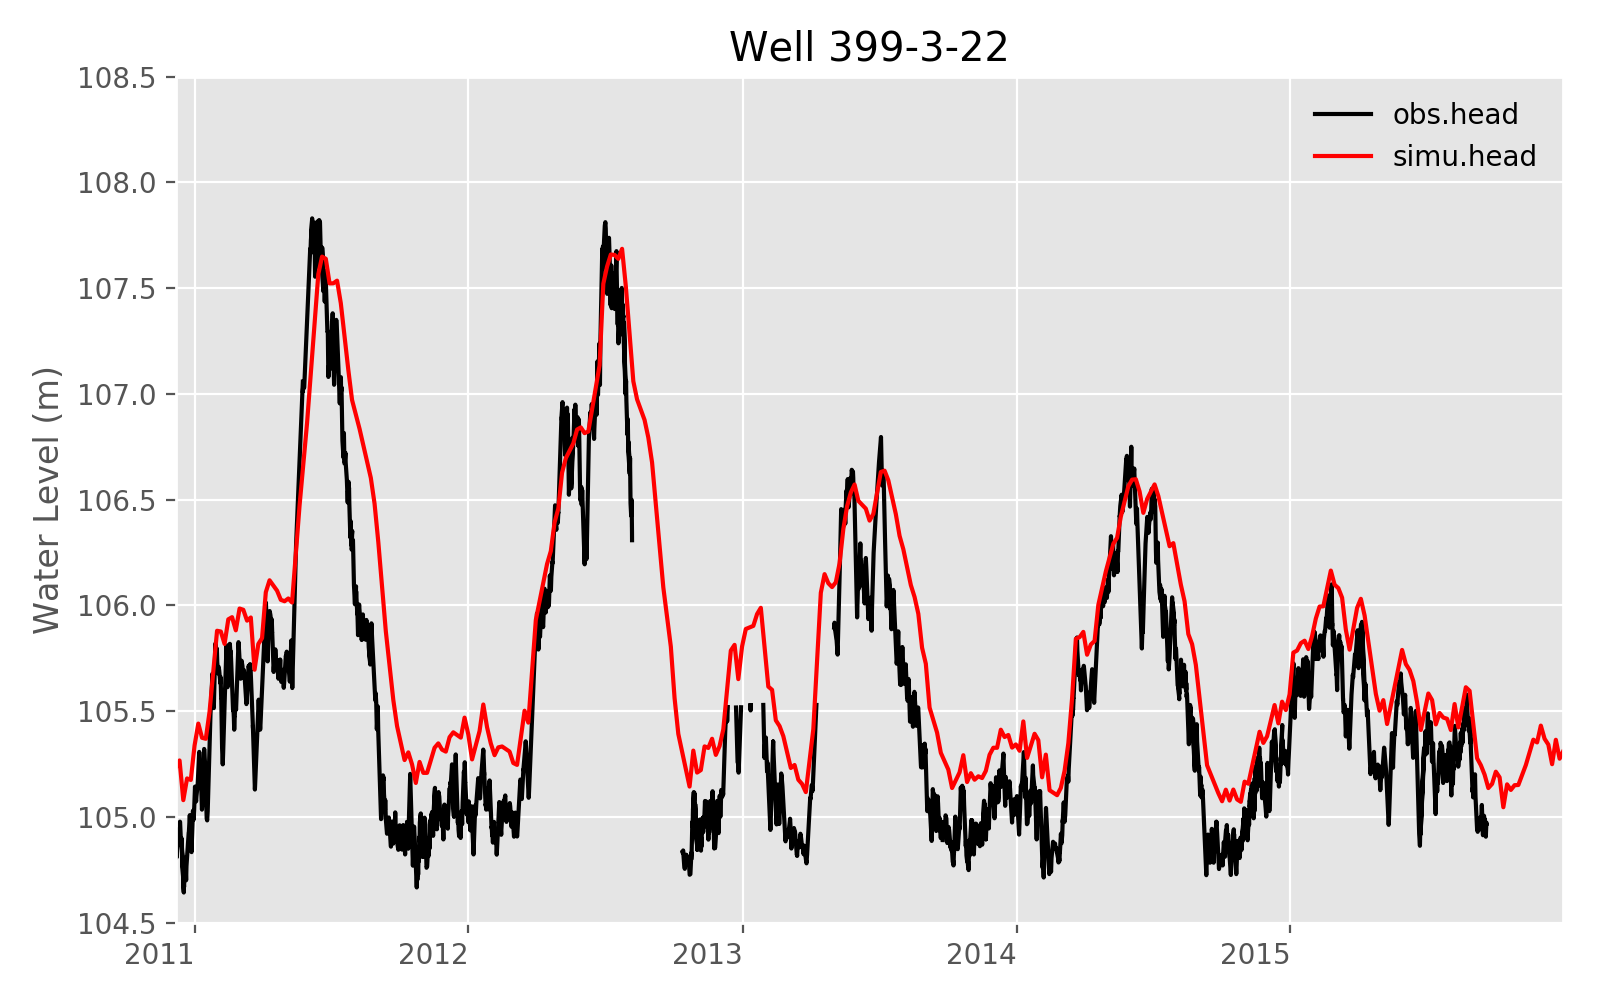

399-3-34


<IPython.core.display.Javascript object>


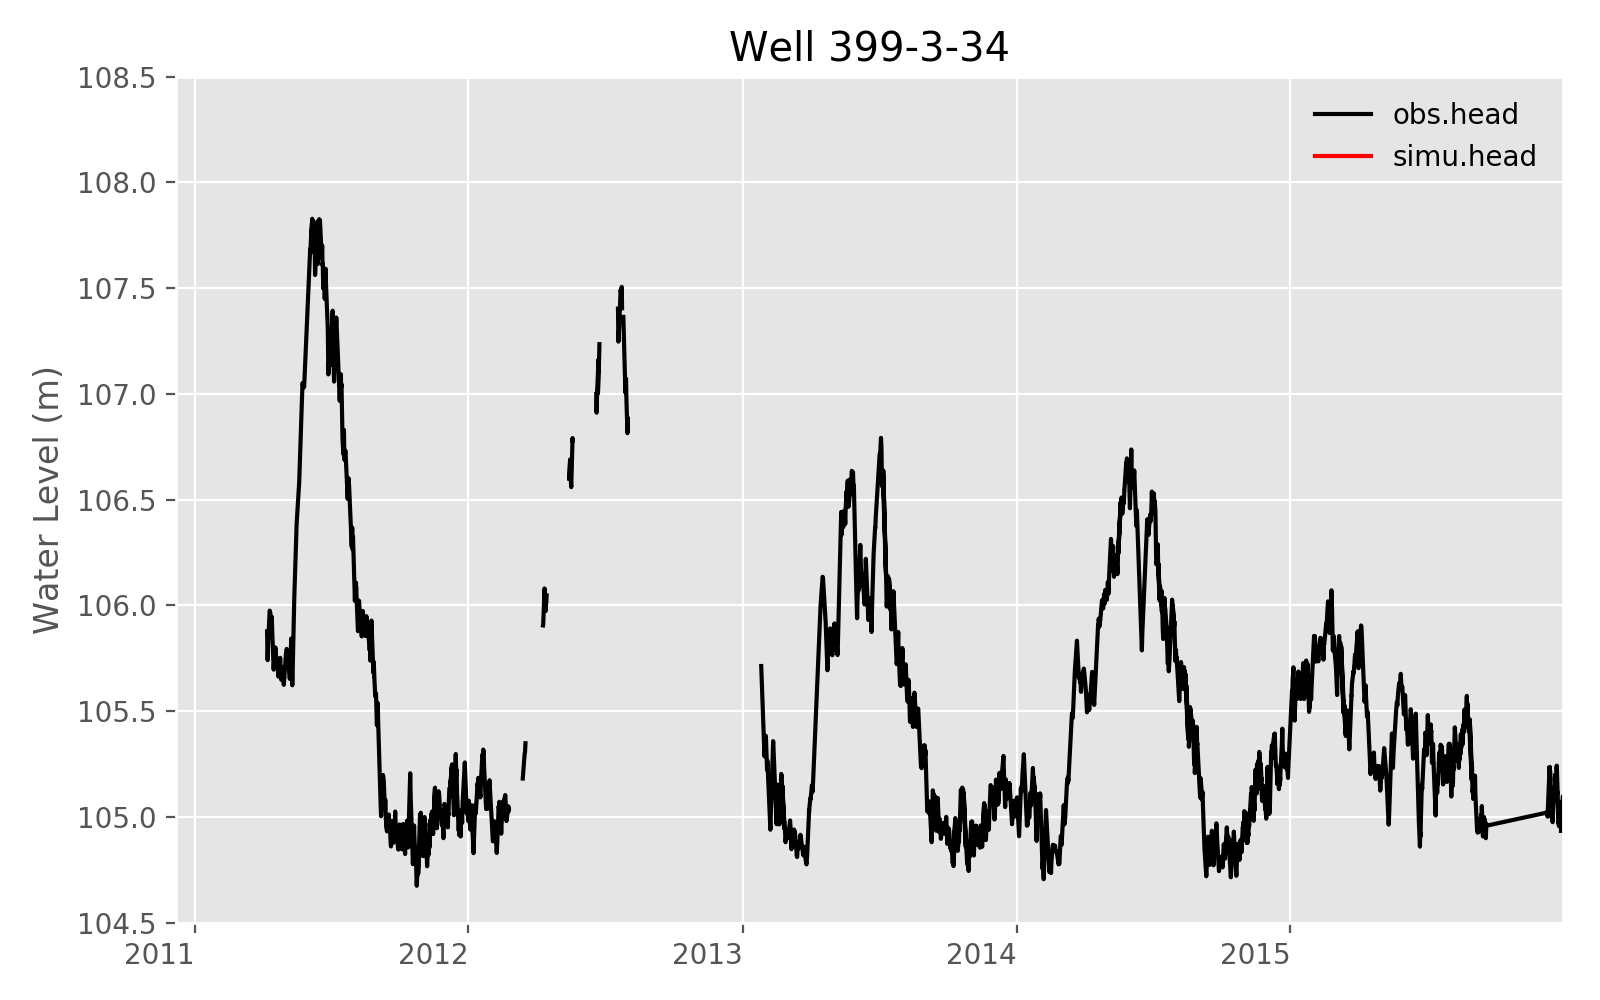

399-3-37


<IPython.core.display.Javascript object>


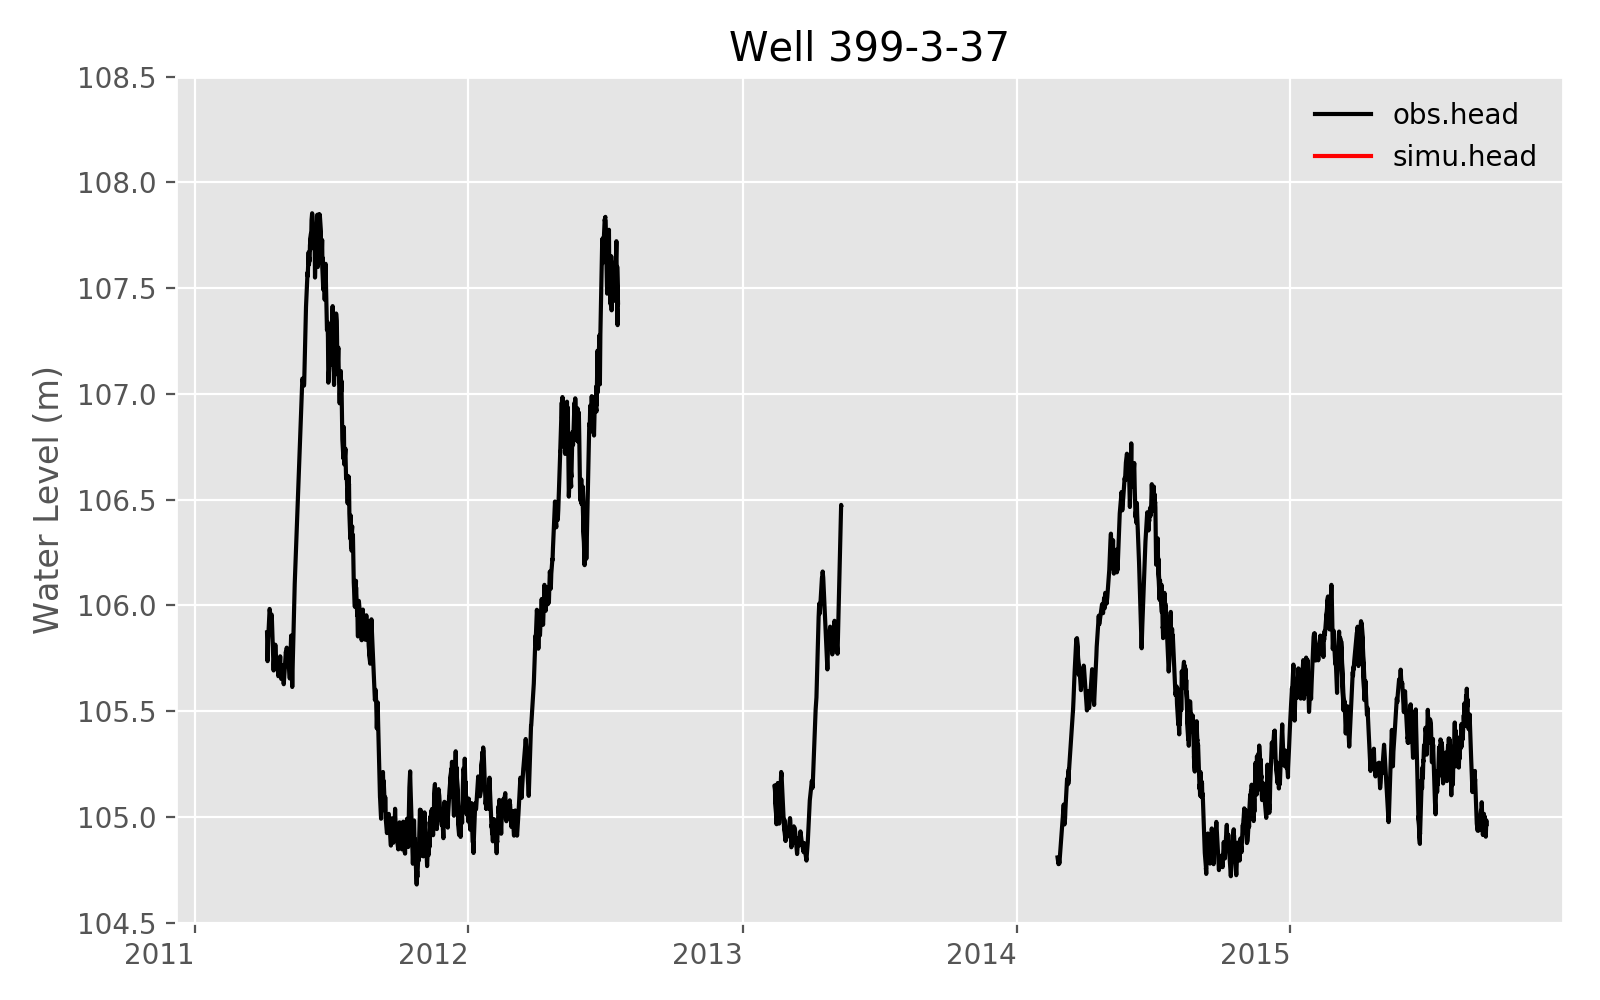

399-4-1
399-4-7


<IPython.core.display.Javascript object>


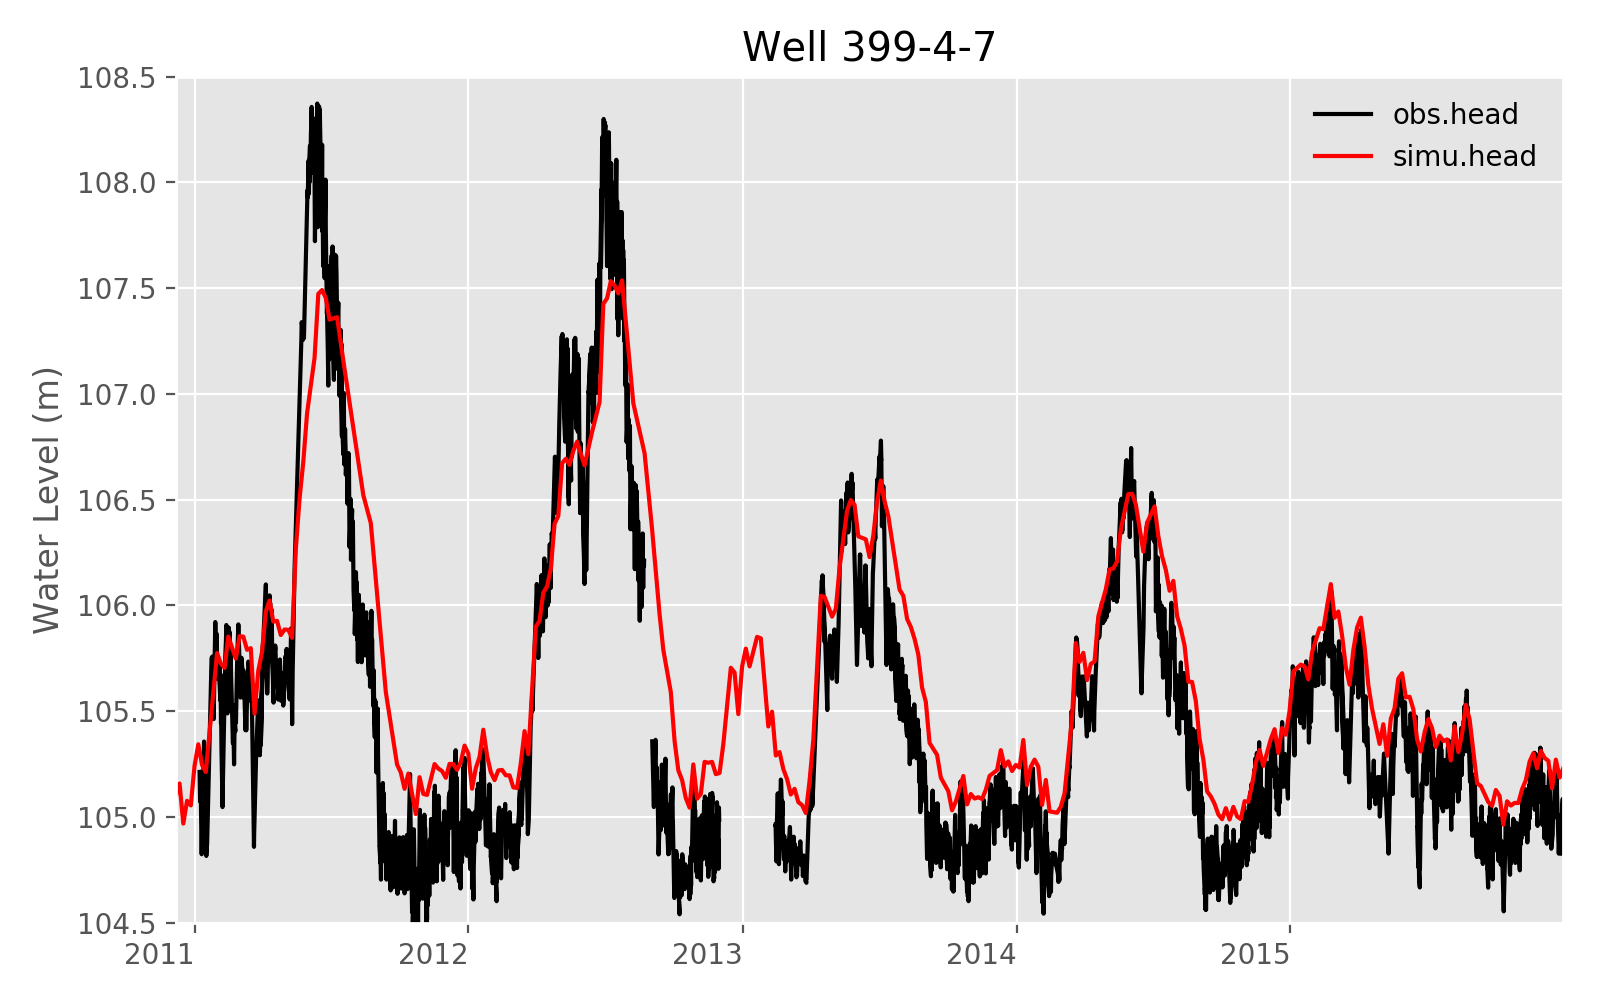

399-4-9


<IPython.core.display.Javascript object>


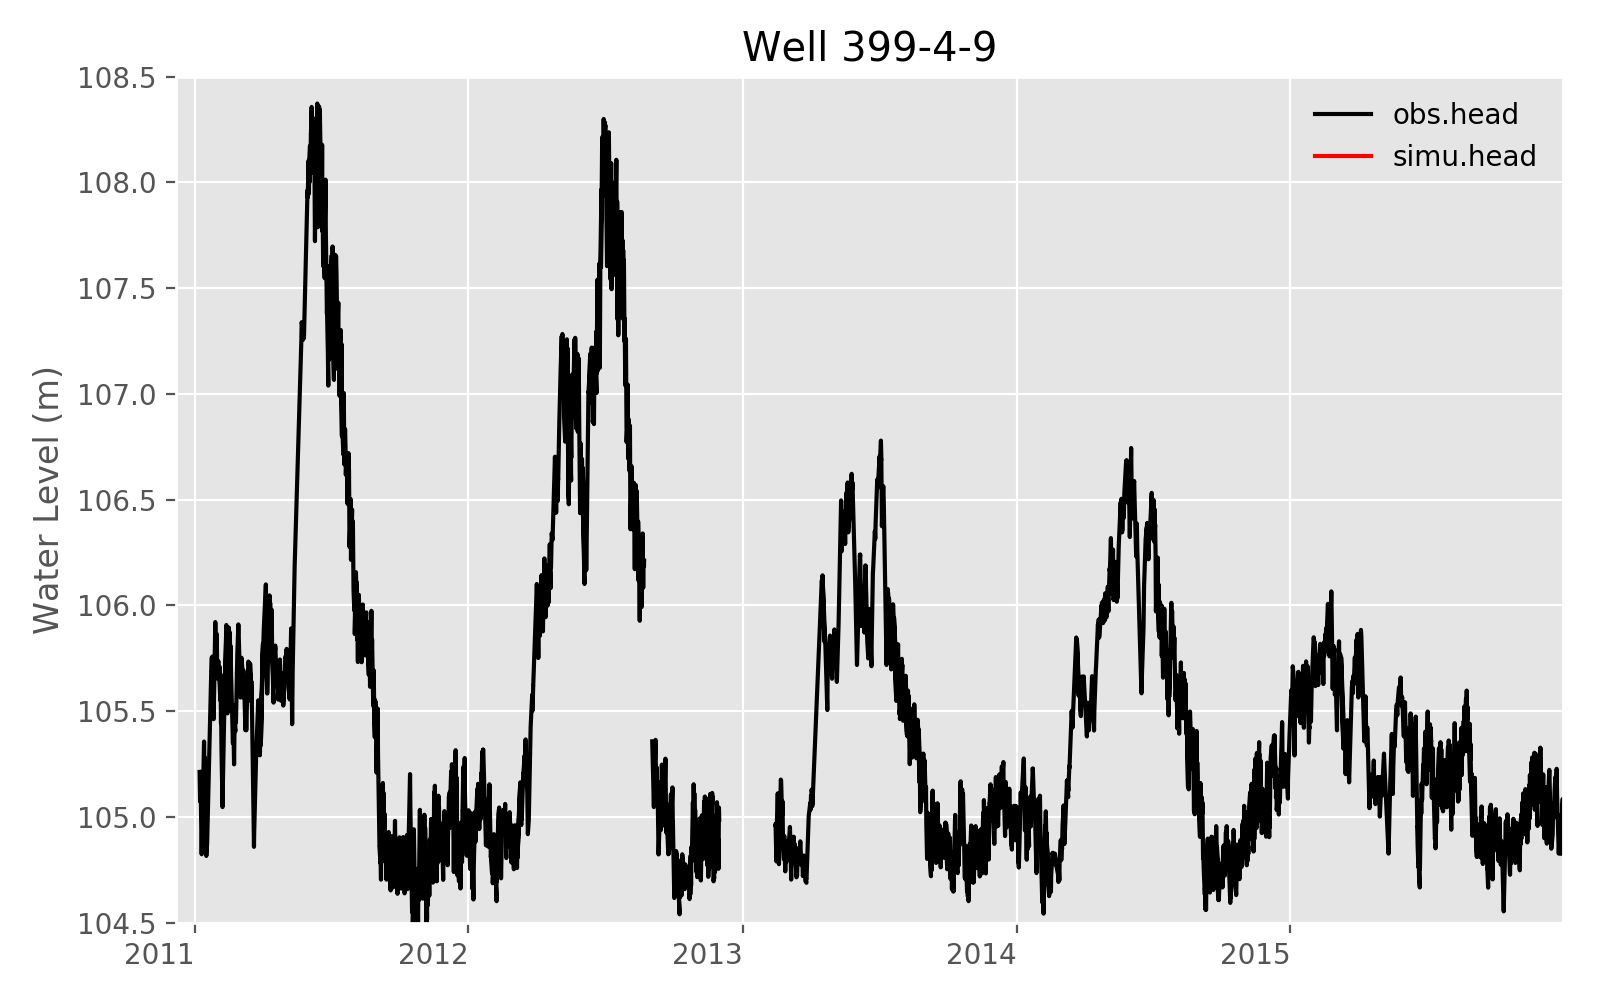

399-4-14


In [263]:

for iwell in well_loc.index[6:]:
#     iwell = '399-1-10A'
    print(iwell)
    iwell_interval_index = np.where((z > well_loc.loc[iwell, 'SCREEN_ELEV_BOTTOM']) \
                                    & (z < well_loc.loc[iwell, 'SCREEN_ELEV_TOP']))
    iwell_interval_index = np.asarray(iwell_interval_index).flatten()
    # well head is taken at the lowest screen interval--iwell_interval_index[0]
    isimu_head = well_simu_head[:, iwell_interval_index[0], np.asarray(np.where(well_loc.index == iwell)).flatten()]
    isimu_head = isimu_head.reshape(isimu_head.shape[0])
    # read obs.head
    iobs_head_df = well_data[ well_data.loc[:, 'WellName'] == iwell].copy()
    iobs_head_df['DateTime'] = iobs_head_df['DateTime'].apply(pd.to_datetime)
    
    if iobs_head_df.size > 0:
        ##================= plot simu vs obs head========================##
        # fig = plt.figure() # open a canvas
        # ax = fig.add_subplot(1, 1, 1) # create 1st subplot on a 1x1 grid
        fig, ax = plt.subplots(1, 1) # short hand

        # plt.plot(iobs_datetime.iloc[:], iobs_head_df['WL'], 'k-')
        # plt.plot(iobs_head_df['DateTime'], iobs_head_df['WL'])


        iobs_head_df.plot(x= 'DateTime', y= 'WL', color='k', legend=False, ax=ax, 
                         figsize = (8, 5), title = 'Well ' + iwell,
                         rot = 0)
        plt.plot(real_time_index, isimu_head, 'r-')

        ax.set_xlim([real_time_index[0], real_time_index[-1]])
        ax.set_ylim([104.5, 108.5])
        ax.set_ylabel('Water Level (m)')
        ax.set_xlabel('')
        ax.legend(['obs.head', 'simu.head'], frameon = False)

        fig.tight_layout()
        fname = fig_simu_obs_wl + 'Well ' + iwell 
        fig.savefig(fname , dpi=300)
        plt.close(fig)

# plot groundwater level contour 

<IPython.core.display.Javascript object>


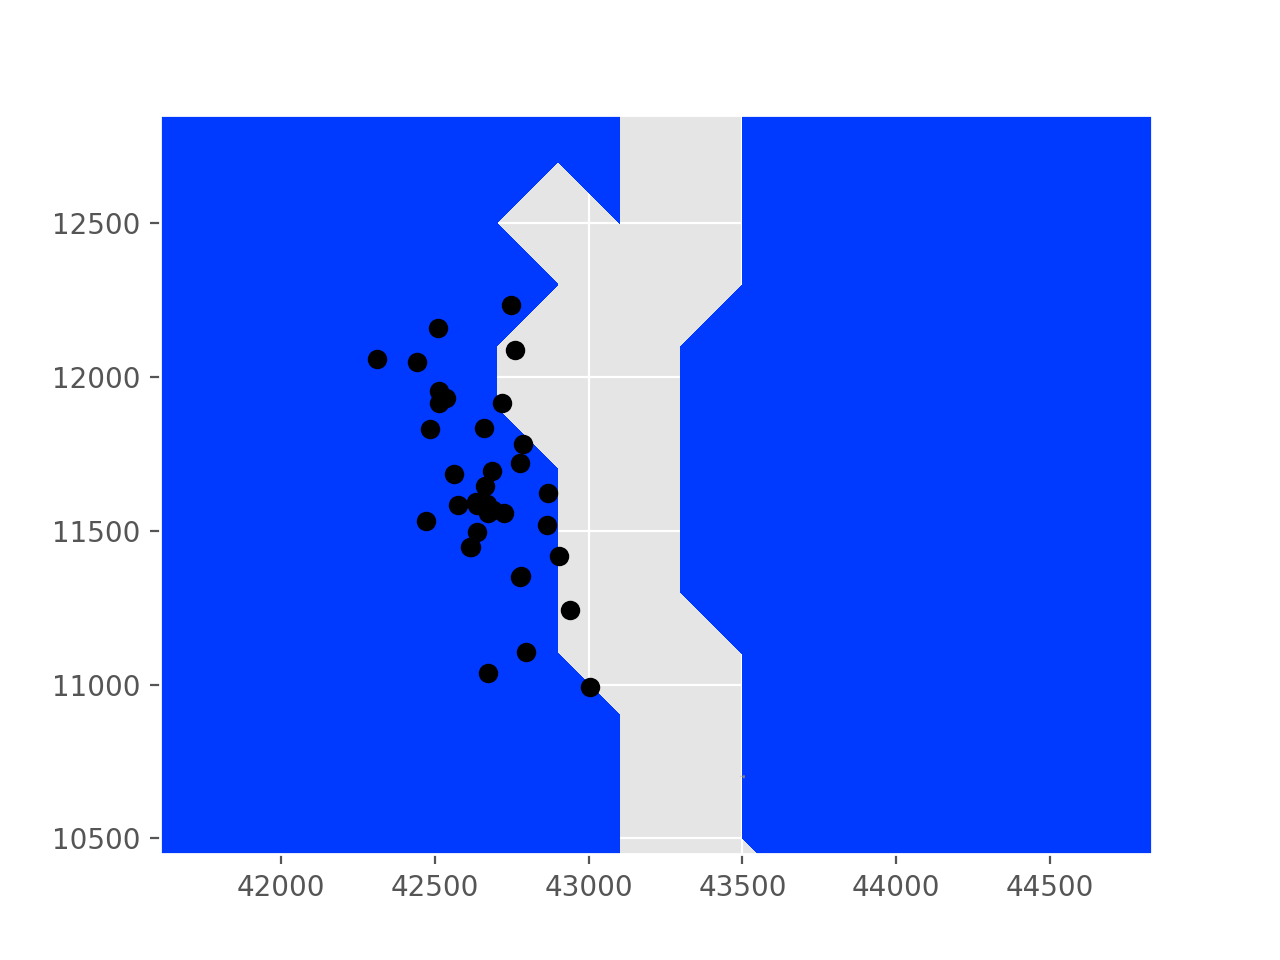

<a list of 62 text.Text objects>

In [256]:
iz = interval_index[-7]
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
# plot contour
cf1 = ax1.contourf(x, y, temp_total_head[iz, :,:],
                   cmap=plt.cm.jet,
                   vmin=100,
                   vmax=130,
                   extend="both",
                   levels=np.arange(100, 130.1, 1)
                   )
# plot contour lines
cf2 = plt.contour(cf1, colors='grey', levels=np.arange(100, 130.1, 1))
ax1.set_aspect("equal", "datalim")

plt.plot(well_loc['Easting'], well_loc['Northing'], 'ko')
plt.clabel(cf2, inline = True, fmt = '%3.0d', fontsize = 10)
# plt.xlim(42000, 43000)
# plt.ylim(9000, 14000)

note: for plotting contour surface using plt.contour(X,Y,Z), Z must be shape of (ny, nx)

/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/pflotran_200x200x2_1w_bc.h5
Time:  3.24000E+04 h


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'V'
  s)


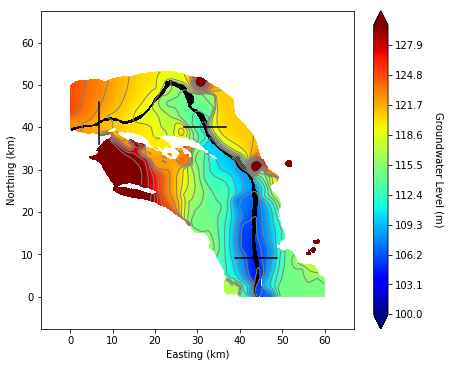

In [107]:
    fig_name = fig_wl + real_itime + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black")
    ax1.plot(line2_x, line2_y, "black")
    ax1.plot(line3_x, line3_y, "black")
    cf1 = ax1.contourf(x / 1000, y / 1000, temp_wl,
                       cmap=plt.cm.jet,
                       levels=np.arange(100, 130.1, 0.1),
                       vmin=100,
                       vmax=130,
                       extend="both",
                       V=np.arange(100, 130.1, 5)
                       )
    cf2 = ax1.contour(x / 1000, y / 1000, temp_wl,
                      colors="grey",
                      levels=np.arange(100, 130.1, 1.5),
                      linewidths=1,
                      vmin=100,
                      vmax=130)

    ax1.set_xlabel("Easting (km)")
    ax1.set_ylabel("Northing (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_aspect("equal", "datalim")
    cb1 = plt.colorbar(cf1, extend="both")  # ,
#                           orientation="horizontal", shrink=0.8, aspect=25)
    cb1.ax.set_ylabel("Groundwater Level (m)", rotation=270, labelpad=20)
    fig.tight_layout()
    cf3 = ax1.contourf(x / 1000, y / 1000, yx_river, colors="black")
    fig.set_size_inches(6.5, 5.5)

In [78]:
        fig.savefig(fig_name, dpi=600, transparent=True)
        plt.close(fig)
input_h5.close()